Setup complete for House 2!
Dataset path: /kaggle/input/redd-dataset/redd
Output path: /kaggle/working/house2_results/
Selected appliances: ['fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']
HOUSE 2 NILM CLASSIFICATION EXPERIMENT - PAPER REPLICATION

Step 1: Visualizing House 2 power profiles...

Visualizing power profiles for House 2...
Processing House 2
Selected 5 appliances: ['fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']
Found 7 files for house 2
Files: ['redd_house2_0.csv', 'redd_house2_1.csv', 'redd_house2_2.csv', 'redd_house2_3.csv', 'redd_house2_4.csv', 'redd_house2_5.csv', 'redd_house2_6.csv']


Loading CSV files:  29%|██▊       | 2/7 [00:00<00:00, 16.46it/s]

First file columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']
Available appliances: ['fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']


Loading CSV files: 100%|██████████| 7/7 [00:00<00:00, 18.85it/s]



Loaded 5,000 samples from House 2
Available columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']

Data Statistics:
Column               Min        Max        Mean       Std        % Non-zero
--------------------------------------------------------------------------------
main                 37.52      1277.22    119.96     114.76     100.0     
fridge               6.00       189.00     59.19      74.23      100.0     
microwave            4.00       5.00       4.41       0.49       100.0     
washer_dryer         2.00       5.00       3.73       0.50       100.0     
dish_washer          0.00       1.00       0.09       0.29       9.0       
electric_stove       0.00       1.00       0.63       0.48       63.1      


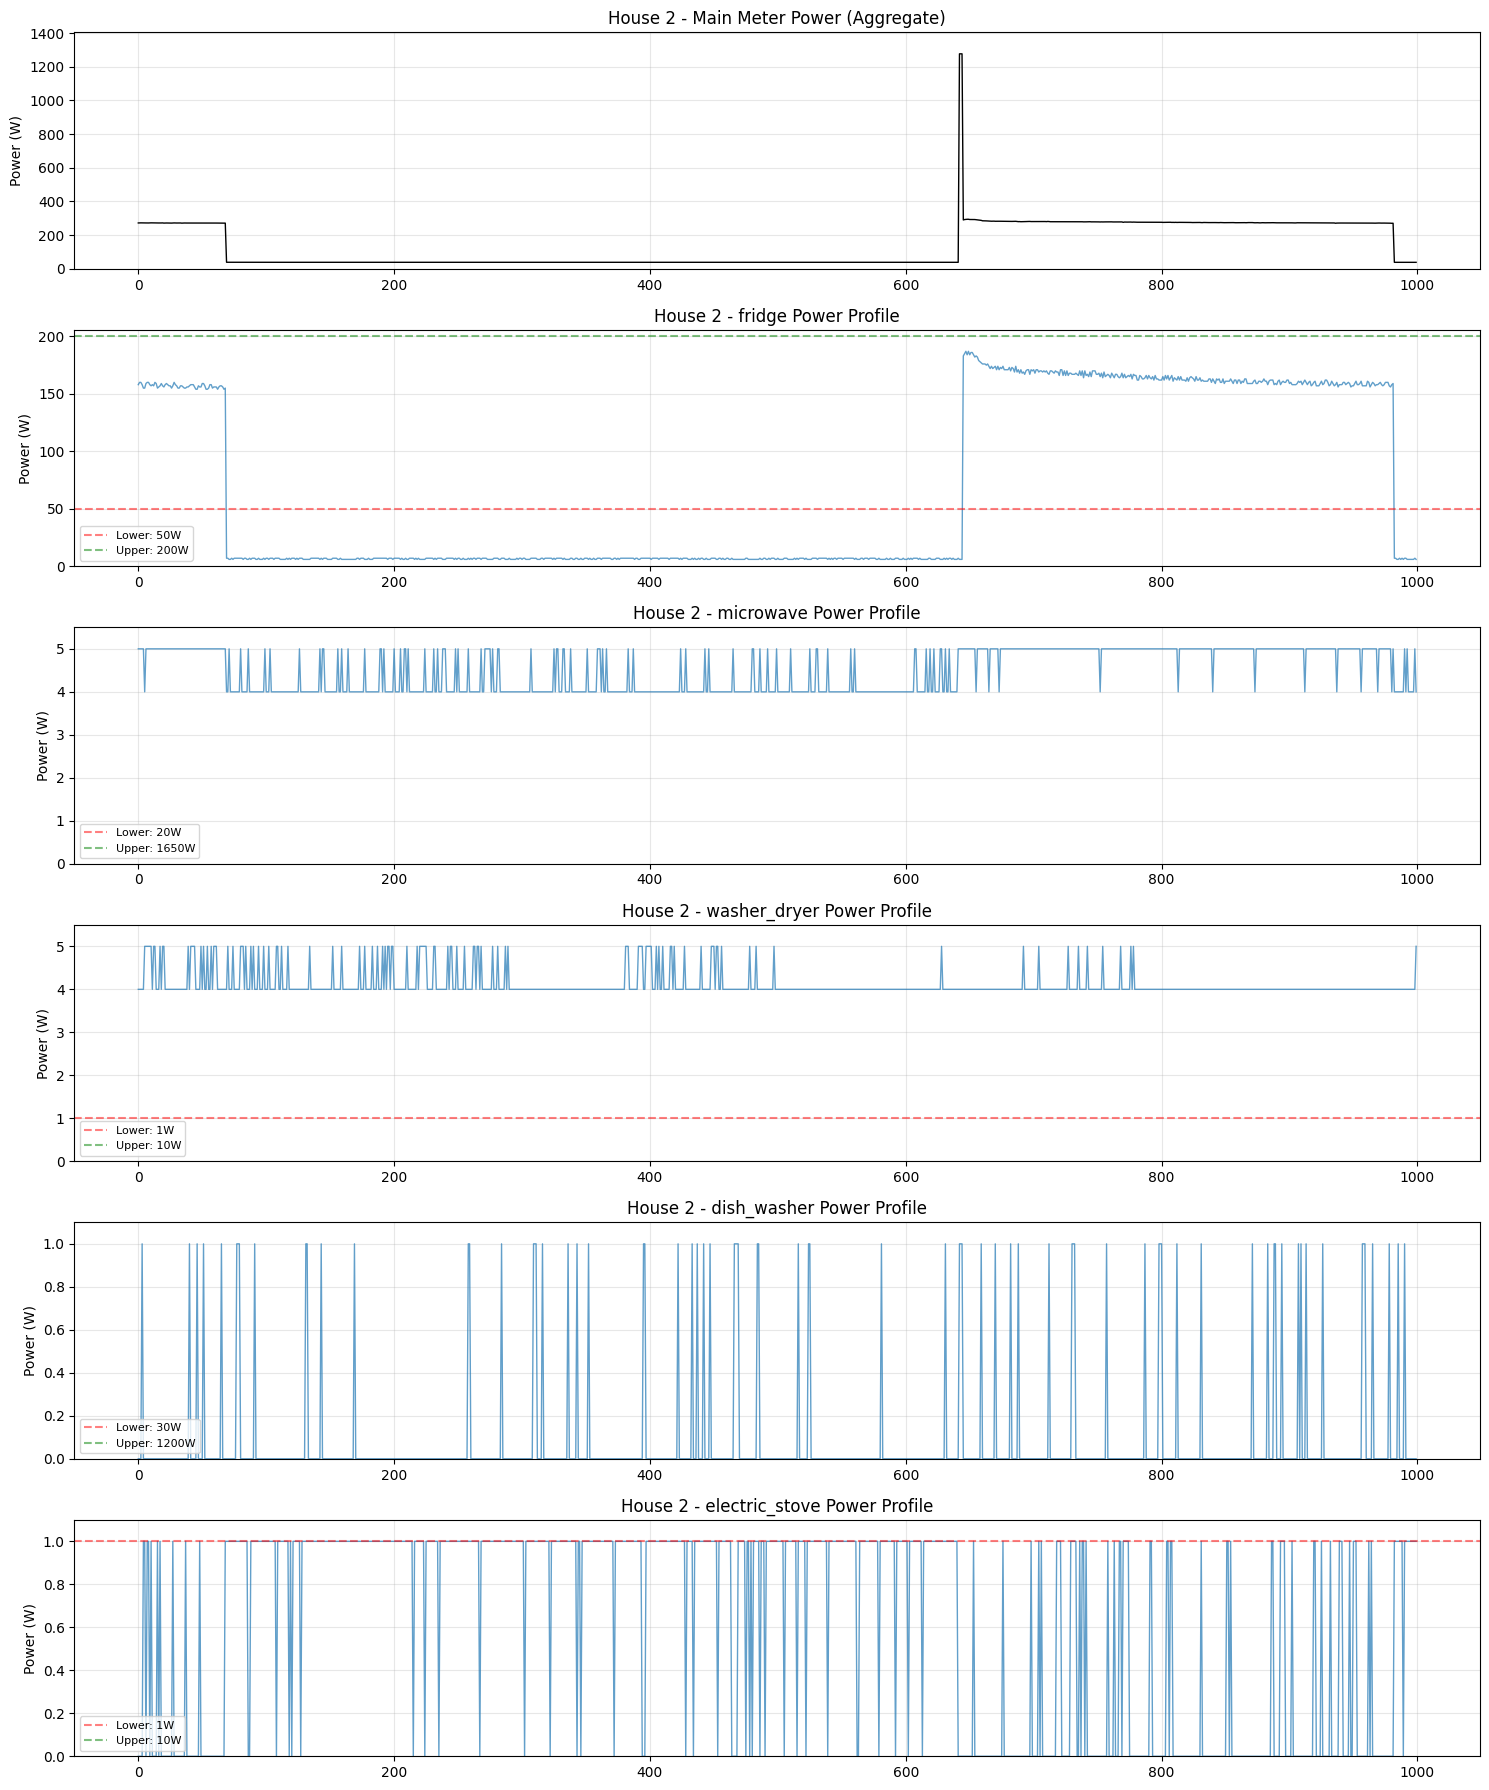


House 2 Power Statistics:
Appliance            Min (W)    Max (W)    Mean (W)   Std (W)    % Non-zero
--------------------------------------------------------------------------------
fridge               6.0        189.0      59.2       74.2       100.0     
microwave            4.0        5.0        4.4        0.5        100.0     
washer_dryer         2.0        5.0        3.7        0.5        100.0     
dish_washer          0.0        1.0        0.1        0.3        9.0       
electric_stove       0.0        1.0        0.6        0.5        63.1      

Step 2: Running comprehensive experiments for House 2...

House 2 Configuration: With_Windowing, Threshold=5

################################################################################
HOUSE 2 EXPERIMENT: Threshold=5, Windowing=ON
################################################################################
Processing House 2
Selected 5 appliances: ['fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']
Fo

Loading CSV files: 100%|██████████| 7/7 [00:00<00:00, 39.87it/s]

First file columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']
Available appliances: ['fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']

Loaded 292,063 samples from House 2
Available columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']

Data Statistics:
Column               Min        Max        Mean       Std        % Non-zero
--------------------------------------------------------------------------------
main                 36.36      3232.98    236.19     265.98     100.0     


fridge               0.00       2246.00    81.72      88.50      100.0     
microwave            0.00       1956.00    16.39      117.73     100.0     
washer_dryer         0.00       55.00      2.19       0.72       98.8      
dish_washer          0.00       1457.00    10.78      105.10     8.8       
electric_stove       0.00       457.00     1.62       20.73      48.8      

Applying Power Windowing (Paper Table 3 Methodology)

fridge              : Window [  50W,  200W]
  Before: 292,052 ON (100.0%)
  After:  127,917 ON ( 43.8%)
  Changed: 164,135 instances

microwave           : Window [  20W, 1650W]
  Before: 292,062 ON (100.0%)
  After:   30,088 ON ( 10.3%)
  Changed: 261,974 instances

washer_dryer        : Window [   1W,   10W]
  Before: 288,456 ON ( 98.8%)
  After:  288,454 ON ( 98.8%)
  Changed:       2 instances

dish_washer         : Window [  30W, 1200W]
  Before:  25,833 ON (  8.8%)
  After:    3,520 ON (  1.2%)
  Changed:  22,313 instances

electric_stove      : Window 

Training classifiers:   0%|          | 0/7 [00:00<?, ?it/s]


Training CART...


Training classifiers:  14%|█▍        | 1/7 [00:00<00:03,  1.64it/s]

 ✓ Trained in 0.44s
   Macro F1: 0.3329
   Weighted F1: 0.7551
   Accuracy: 0.7835

Training ET...


Training classifiers:  29%|██▊       | 2/7 [00:06<00:19,  3.85s/it]

 ✓ Trained in 5.16s
   Macro F1: 0.3358
   Weighted F1: 0.7561
   Accuracy: 0.7847

Training KNN...


Training classifiers:  43%|████▎     | 3/7 [00:09<00:12,  3.21s/it]

 ✓ Trained in 0.10s
   Macro F1: 0.3093
   Weighted F1: 0.7577
   Accuracy: 0.7838

Training KNN-CB...


Training classifiers:  57%|█████▋    | 4/7 [00:09<00:06,  2.21s/it]

 ✓ Trained in 0.10s
   Macro F1: 0.3464
   Weighted F1: 0.7610
   Accuracy: 0.7881

Training LDA...


Training classifiers:  71%|███████▏  | 5/7 [00:10<00:03,  1.51s/it]

 ✓ Trained in 0.10s
   Macro F1: 0.0763
   Weighted F1: 0.5859
   Accuracy: 0.6904

Training NB...


Training classifiers:  86%|████████▌ | 6/7 [00:10<00:01,  1.07s/it]

 ✓ Trained in 0.04s
   Macro F1: 0.0755
   Weighted F1: 0.5896
   Accuracy: 0.6818

Training RF...


Training classifiers: 100%|██████████| 7/7 [00:25<00:00,  3.60s/it]

 ✓ Trained in 13.99s
   Macro F1: 0.3307
   Weighted F1: 0.7570
   Accuracy: 0.7858


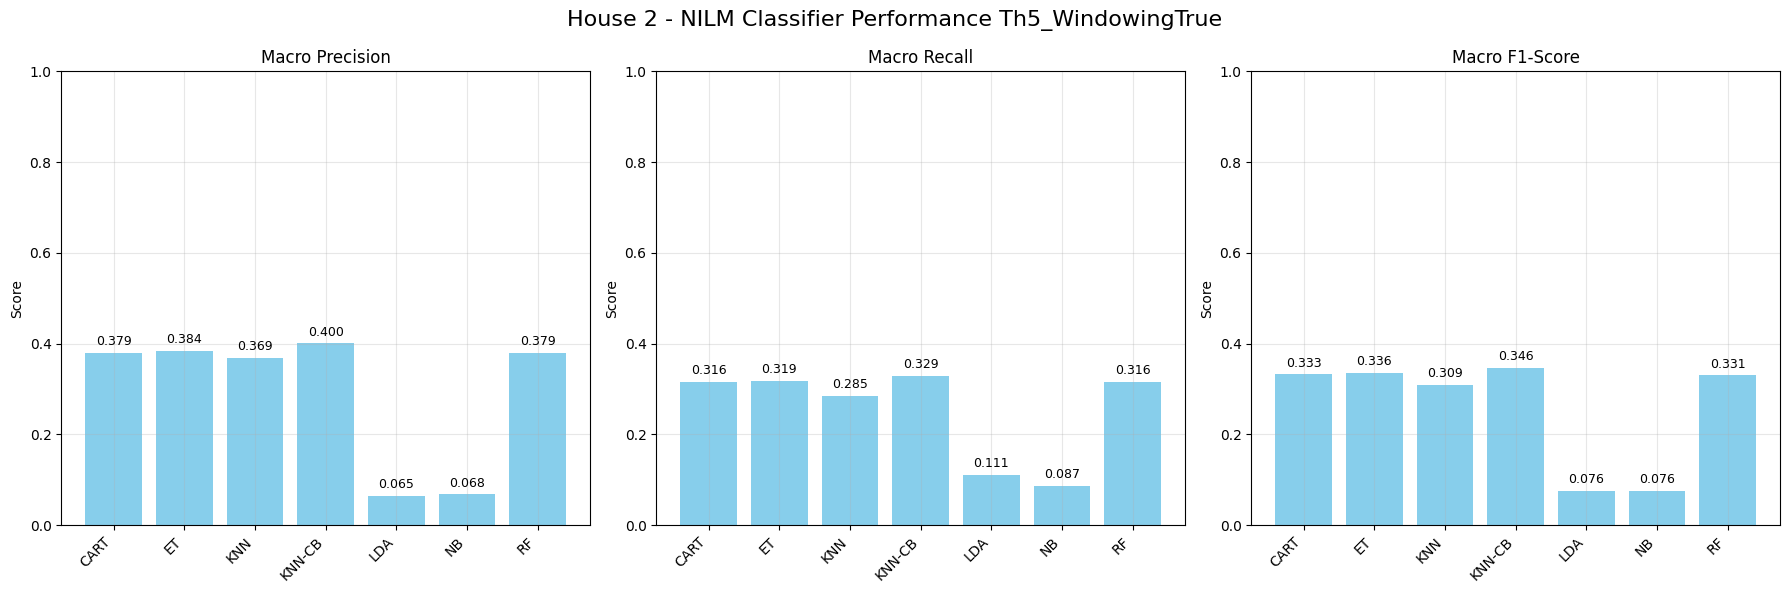

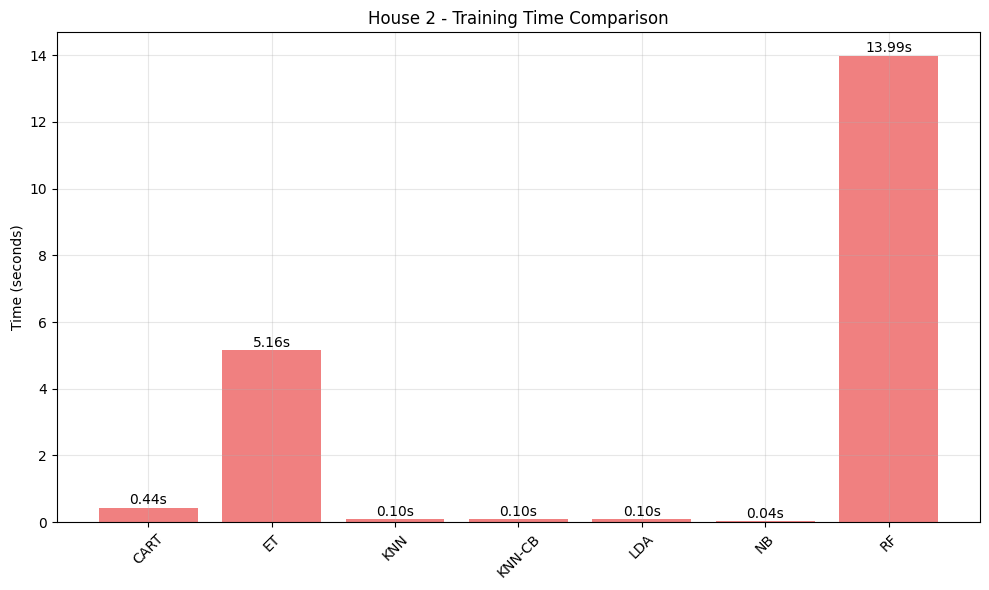


HOUSE 2 PERFORMANCE SUMMARY
Classifier   Accuracy   Macro F1   Weighted F1  Time (s)  
--------------------------------------------------------------------------------
CART         0.7835     0.3329     0.7551       0.44      
ET           0.7847     0.3358     0.7561       5.16      
KNN          0.7838     0.3093     0.7577       0.10      
KNN-CB       0.7881     0.3464     0.7610       0.10      
LDA          0.6904     0.0763     0.5859       0.10      
NB           0.6818     0.0755     0.5896       0.04      
RF           0.7858     0.3307     0.7570       13.99     

Results saved to: /kaggle/working/house2_results/house2_results_Th5_WindowingTrue.pkl

House 2 Configuration: With_Windowing, Threshold=10

################################################################################
HOUSE 2 EXPERIMENT: Threshold=10, Windowing=ON
################################################################################
Processing House 2
Selected 5 appliances: ['fridge', 'microwave', 'w

Loading CSV files:  71%|███████▏  | 5/7 [00:00<00:00, 48.22it/s]

First file columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']
Available appliances: ['fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']


Loading CSV files: 100%|██████████| 7/7 [00:00<00:00, 40.74it/s]



Loaded 292,063 samples from House 2
Available columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']

Data Statistics:
Column               Min        Max        Mean       Std        % Non-zero
--------------------------------------------------------------------------------
main                 36.36      3232.98    236.19     265.98     100.0     
fridge               0.00       2246.00    81.72      88.50      100.0     
microwave            0.00       1956.00    16.39      117.73     100.0     
washer_dryer         0.00       55.00      2.19       0.72       98.8      
dish_washer          0.00       1457.00    10.78      105.10     8.8       
electric_stove       0.00       457.00     1.62       20.73      48.8      

Applying Power Windowing (Paper Table 3 Methodology)

fridge              : Window [  50W,  200W]
  Before: 292,052 ON (100.0%)
  After:  127,917 ON ( 43.8%)
  Changed: 164,135 instances

microwave           : Window [  20W, 1650W]

Training classifiers:   0%|          | 0/7 [00:00<?, ?it/s]


Training CART...


Training classifiers:  14%|█▍        | 1/7 [00:00<00:03,  1.57it/s]

 ✓ Trained in 0.45s
   Macro F1: 0.3459
   Weighted F1: 0.7552
   Accuracy: 0.7838

Training ET...


Training classifiers:  29%|██▊       | 2/7 [00:06<00:18,  3.73s/it]

 ✓ Trained in 4.97s
   Macro F1: 0.3459
   Weighted F1: 0.7562
   Accuracy: 0.7849

Training KNN...


Training classifiers:  43%|████▎     | 3/7 [00:09<00:12,  3.20s/it]

 ✓ Trained in 0.10s
   Macro F1: 0.3210
   Weighted F1: 0.7540
   Accuracy: 0.7795

Training KNN-CB...


Training classifiers:  57%|█████▋    | 4/7 [00:09<00:06,  2.20s/it]

 ✓ Trained in 0.10s
   Macro F1: 0.3585
   Weighted F1: 0.7617
   Accuracy: 0.7891

Training LDA...


Training classifiers:  86%|████████▌ | 6/7 [00:10<00:01,  1.05s/it]

 ✓ Trained in 0.09s
   Macro F1: 0.0798
   Weighted F1: 0.5859
   Accuracy: 0.6904

Training NB...
 ✓ Trained in 0.03s
   Macro F1: 0.0789
   Weighted F1: 0.5896
   Accuracy: 0.6818

Training RF...


Training classifiers: 100%|██████████| 7/7 [00:25<00:00,  3.60s/it]

 ✓ Trained in 14.06s
   Macro F1: 0.3361
   Weighted F1: 0.7563
   Accuracy: 0.7854


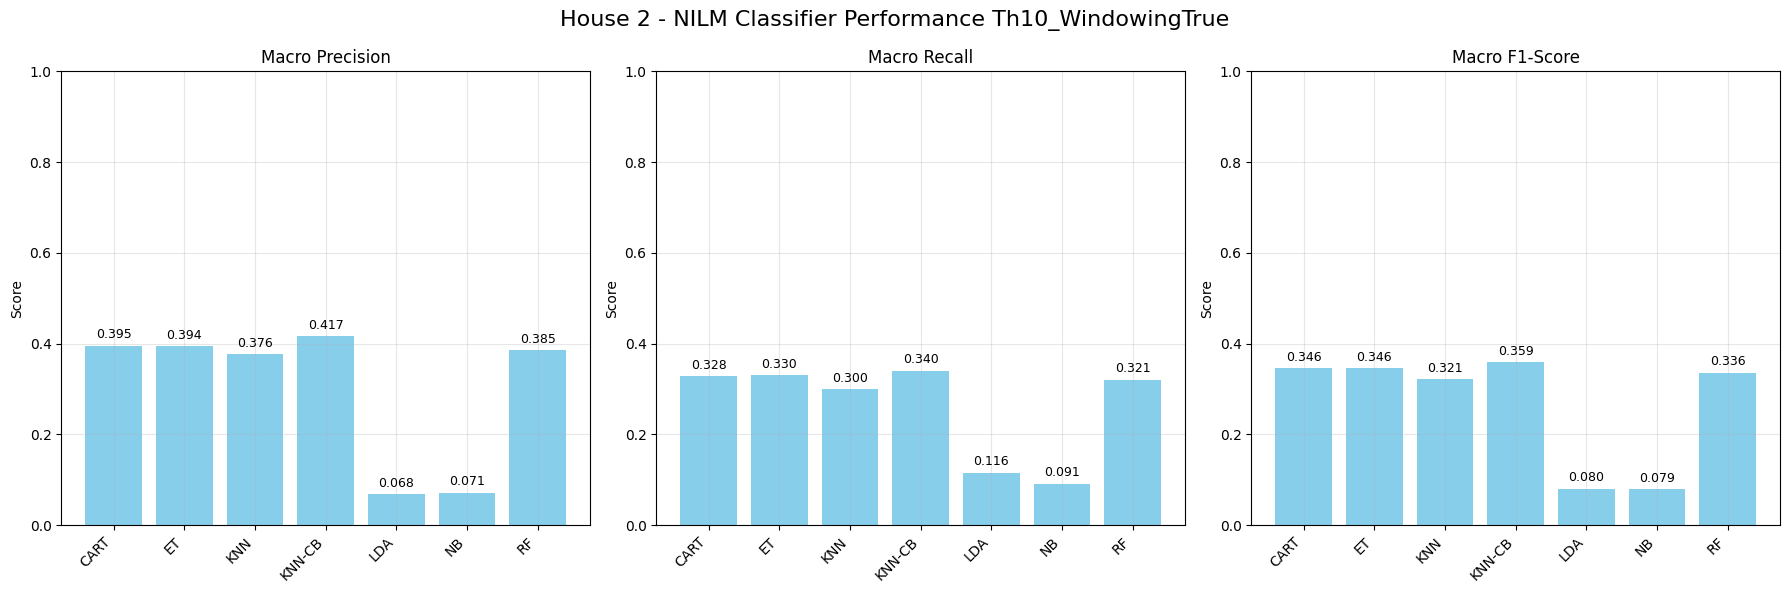

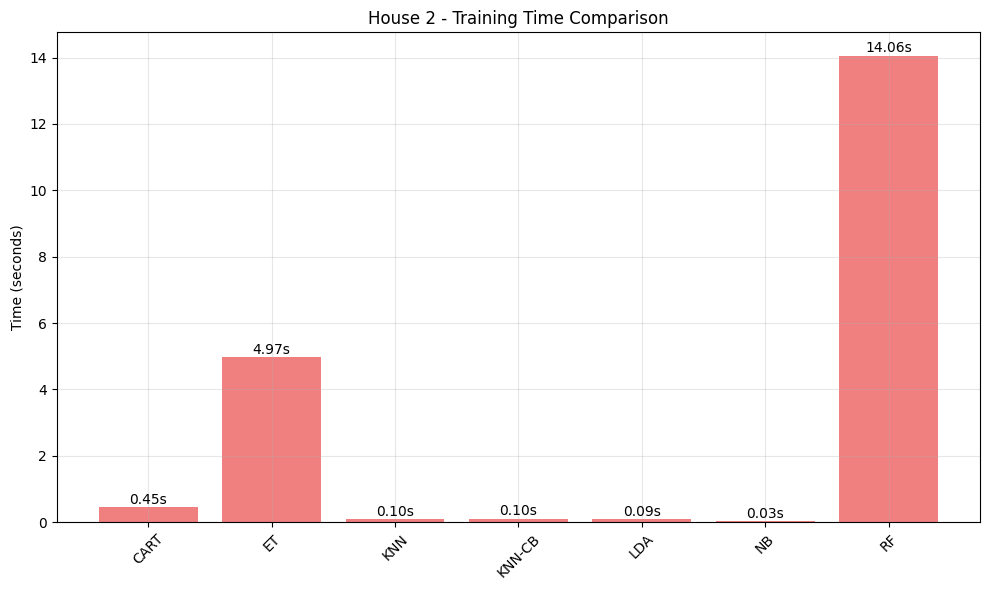


HOUSE 2 PERFORMANCE SUMMARY
Classifier   Accuracy   Macro F1   Weighted F1  Time (s)  
--------------------------------------------------------------------------------
CART         0.7838     0.3459     0.7552       0.45      
ET           0.7849     0.3459     0.7562       4.97      
KNN          0.7795     0.3210     0.7540       0.10      
KNN-CB       0.7891     0.3585     0.7617       0.10      
LDA          0.6904     0.0798     0.5859       0.09      
NB           0.6818     0.0789     0.5896       0.03      
RF           0.7854     0.3361     0.7563       14.06     

Results saved to: /kaggle/working/house2_results/house2_results_Th10_WindowingTrue.pkl

House 2 Configuration: With_Windowing, Threshold=20

################################################################################
HOUSE 2 EXPERIMENT: Threshold=20, Windowing=ON
################################################################################
Processing House 2
Selected 5 appliances: ['fridge', 'microwave', '

Loading CSV files:  71%|███████▏  | 5/7 [00:00<00:00, 46.78it/s]

First file columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']
Available appliances: ['fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']


Loading CSV files: 100%|██████████| 7/7 [00:00<00:00, 40.27it/s]



Loaded 292,063 samples from House 2
Available columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']

Data Statistics:
Column               Min        Max        Mean       Std        % Non-zero
--------------------------------------------------------------------------------
main                 36.36      3232.98    236.19     265.98     100.0     
fridge               0.00       2246.00    81.72      88.50      100.0     
microwave            0.00       1956.00    16.39      117.73     100.0     
washer_dryer         0.00       55.00      2.19       0.72       98.8      
dish_washer          0.00       1457.00    10.78      105.10     8.8       
electric_stove       0.00       457.00     1.62       20.73      48.8      

Applying Power Windowing (Paper Table 3 Methodology)

fridge              : Window [  50W,  200W]
  Before: 292,052 ON (100.0%)
  After:  127,917 ON ( 43.8%)
  Changed: 164,135 instances

microwave           : Window [  20W, 1650W]

Training classifiers:   0%|          | 0/7 [00:00<?, ?it/s]


Training CART...


Training classifiers:  14%|█▍        | 1/7 [00:00<00:03,  1.64it/s]

 ✓ Trained in 0.44s
   Macro F1: 0.3459
   Weighted F1: 0.7552
   Accuracy: 0.7838

Training ET...


Training classifiers:  29%|██▊       | 2/7 [00:06<00:17,  3.60s/it]

 ✓ Trained in 4.73s
   Macro F1: 0.3459
   Weighted F1: 0.7562
   Accuracy: 0.7849

Training KNN...


Training classifiers:  43%|████▎     | 3/7 [00:08<00:12,  3.14s/it]

 ✓ Trained in 0.10s
   Macro F1: 0.3210
   Weighted F1: 0.7540
   Accuracy: 0.7795

Training KNN-CB...


Training classifiers:  57%|█████▋    | 4/7 [00:09<00:06,  2.18s/it]

 ✓ Trained in 0.10s
   Macro F1: 0.3585
   Weighted F1: 0.7617
   Accuracy: 0.7891

Training LDA...


Training classifiers:  86%|████████▌ | 6/7 [00:09<00:01,  1.03s/it]

 ✓ Trained in 0.08s
   Macro F1: 0.0798
   Weighted F1: 0.5859
   Accuracy: 0.6904

Training NB...
 ✓ Trained in 0.03s
   Macro F1: 0.0789
   Weighted F1: 0.5896
   Accuracy: 0.6818

Training RF...


Training classifiers: 100%|██████████| 7/7 [00:24<00:00,  3.53s/it]

 ✓ Trained in 13.89s
   Macro F1: 0.3361
   Weighted F1: 0.7563
   Accuracy: 0.7854


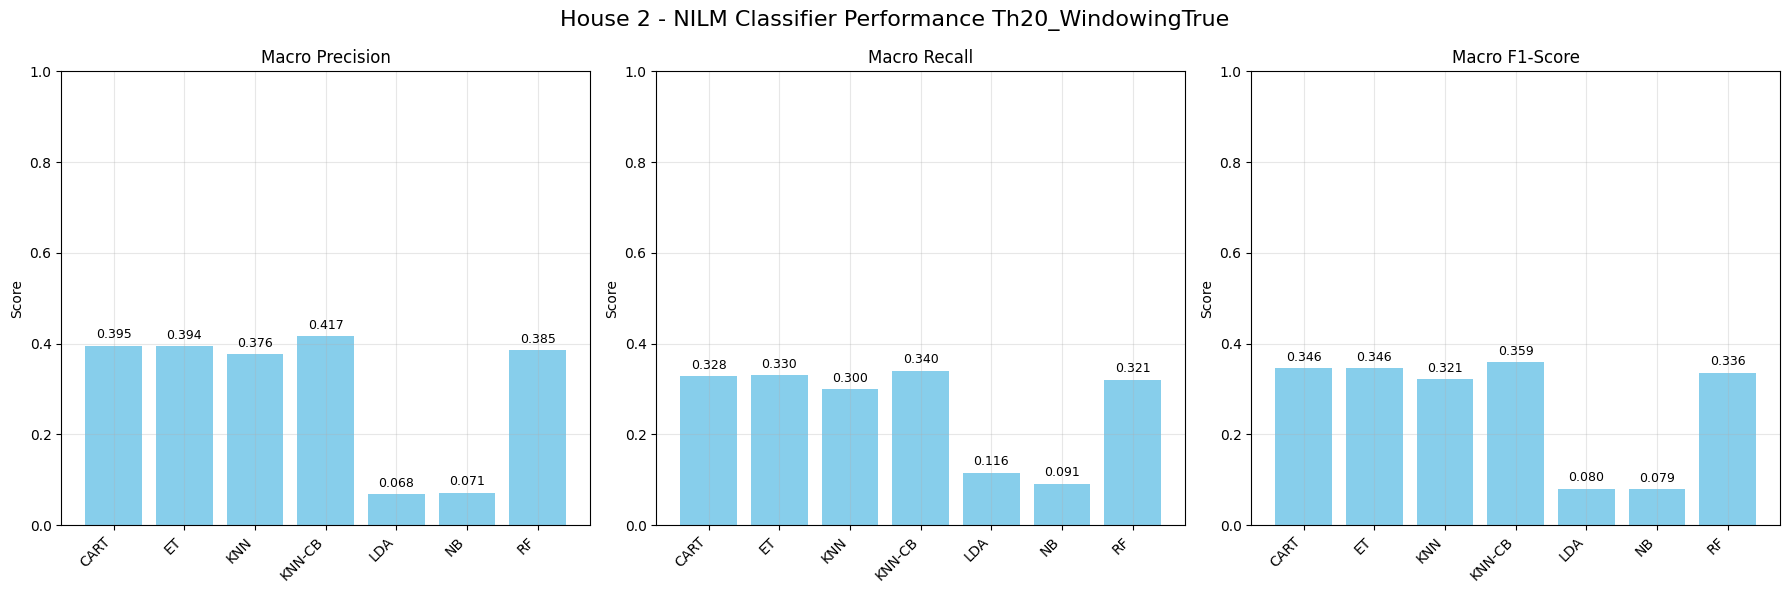

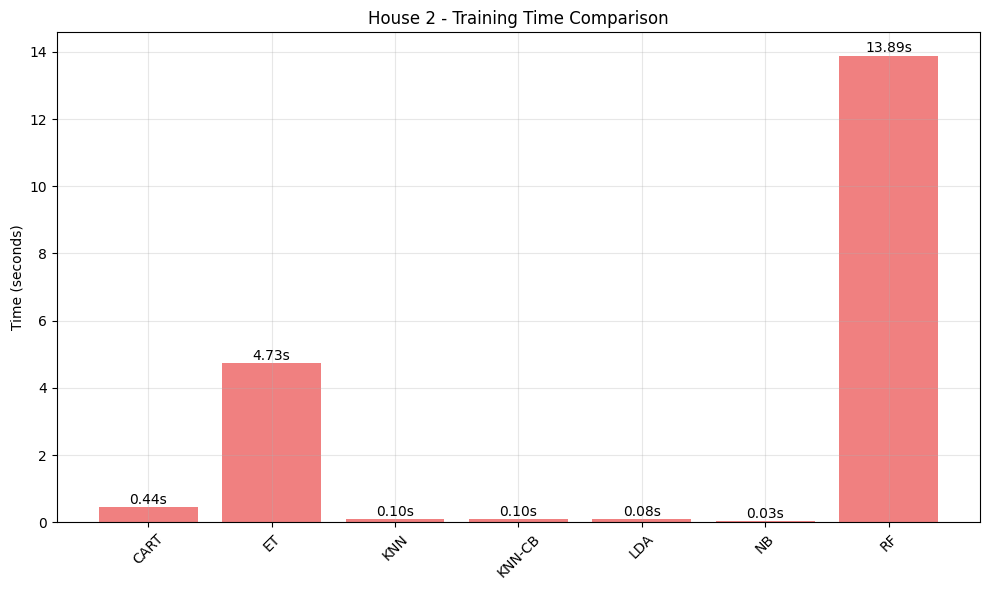


HOUSE 2 PERFORMANCE SUMMARY
Classifier   Accuracy   Macro F1   Weighted F1  Time (s)  
--------------------------------------------------------------------------------
CART         0.7838     0.3459     0.7552       0.44      
ET           0.7849     0.3459     0.7562       4.73      
KNN          0.7795     0.3210     0.7540       0.10      
KNN-CB       0.7891     0.3585     0.7617       0.10      
LDA          0.6904     0.0798     0.5859       0.08      
NB           0.6818     0.0789     0.5896       0.03      
RF           0.7854     0.3361     0.7563       13.89     

Results saved to: /kaggle/working/house2_results/house2_results_Th20_WindowingTrue.pkl

House 2 Configuration: With_Windowing, Threshold=30

################################################################################
HOUSE 2 EXPERIMENT: Threshold=30, Windowing=ON
################################################################################
Processing House 2
Selected 5 appliances: ['fridge', 'microwave', '

Loading CSV files:   0%|          | 0/7 [00:00<?, ?it/s]

First file columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']
Available appliances: ['fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']


Loading CSV files: 100%|██████████| 7/7 [00:00<00:00, 42.22it/s]



Loaded 292,063 samples from House 2
Available columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']

Data Statistics:
Column               Min        Max        Mean       Std        % Non-zero
--------------------------------------------------------------------------------
main                 36.36      3232.98    236.19     265.98     100.0     
fridge               0.00       2246.00    81.72      88.50      100.0     
microwave            0.00       1956.00    16.39      117.73     100.0     
washer_dryer         0.00       55.00      2.19       0.72       98.8      
dish_washer          0.00       1457.00    10.78      105.10     8.8       
electric_stove       0.00       457.00     1.62       20.73      48.8      

Applying Power Windowing (Paper Table 3 Methodology)

fridge              : Window [  50W,  200W]
  Before: 292,052 ON (100.0%)
  After:  127,917 ON ( 43.8%)
  Changed: 164,135 instances

microwave           : Window [  20W, 1650W]

Training classifiers:   0%|          | 0/7 [00:00<?, ?it/s]


Training CART...


Training classifiers:  14%|█▍        | 1/7 [00:00<00:03,  1.63it/s]

 ✓ Trained in 0.44s
   Macro F1: 0.3459
   Weighted F1: 0.7552
   Accuracy: 0.7838

Training ET...


Training classifiers:  29%|██▊       | 2/7 [00:06<00:17,  3.55s/it]

 ✓ Trained in 4.68s
   Macro F1: 0.3459
   Weighted F1: 0.7562
   Accuracy: 0.7849

Training KNN...


Training classifiers:  43%|████▎     | 3/7 [00:08<00:12,  3.08s/it]

 ✓ Trained in 0.10s
   Macro F1: 0.3210
   Weighted F1: 0.7540
   Accuracy: 0.7795

Training KNN-CB...


Training classifiers:  57%|█████▋    | 4/7 [00:09<00:06,  2.13s/it]

 ✓ Trained in 0.10s
   Macro F1: 0.3585
   Weighted F1: 0.7617
   Accuracy: 0.7891

Training LDA...


Training classifiers:  86%|████████▌ | 6/7 [00:09<00:01,  1.01s/it]

 ✓ Trained in 0.08s
   Macro F1: 0.0798
   Weighted F1: 0.5859
   Accuracy: 0.6904

Training NB...
 ✓ Trained in 0.03s
   Macro F1: 0.0789
   Weighted F1: 0.5896
   Accuracy: 0.6818

Training RF...


Training classifiers: 100%|██████████| 7/7 [00:24<00:00,  3.52s/it]

 ✓ Trained in 13.97s
   Macro F1: 0.3361
   Weighted F1: 0.7563
   Accuracy: 0.7854


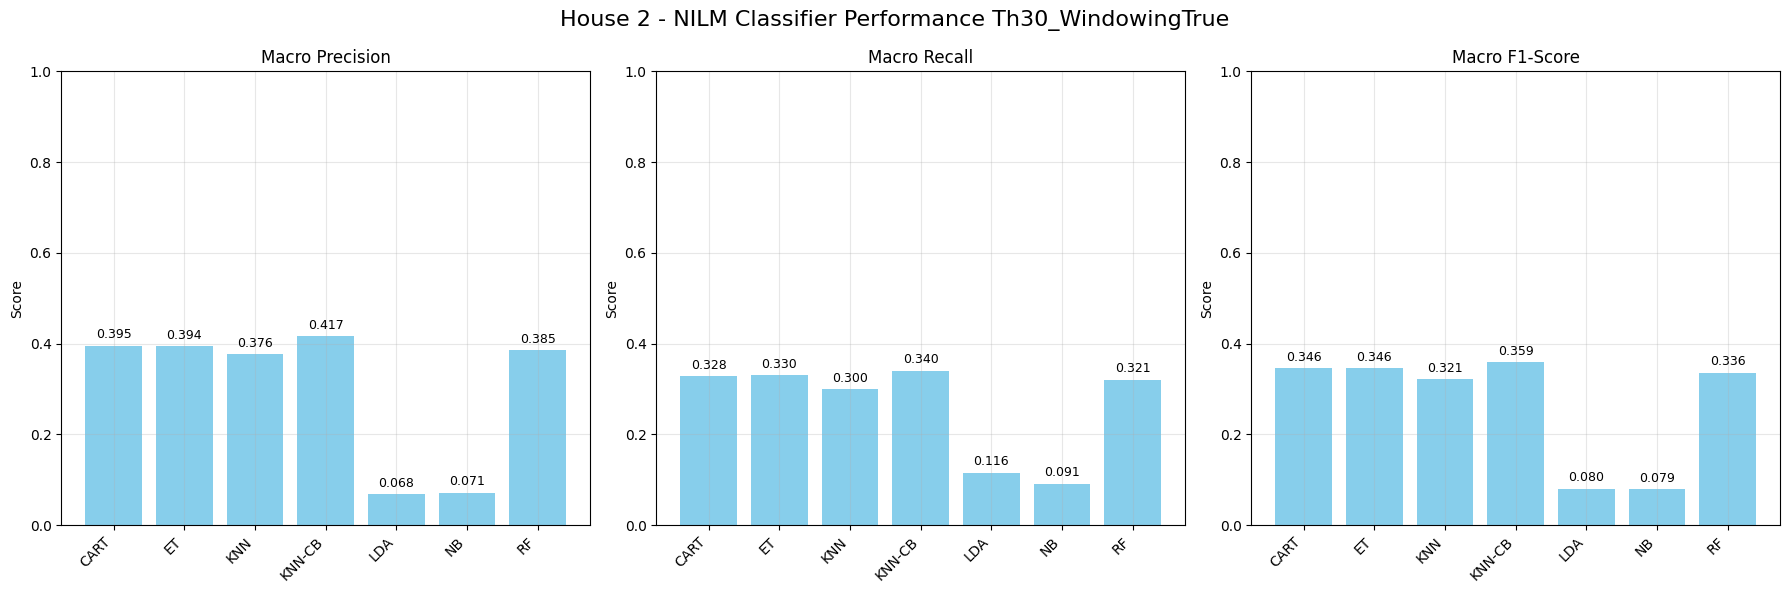

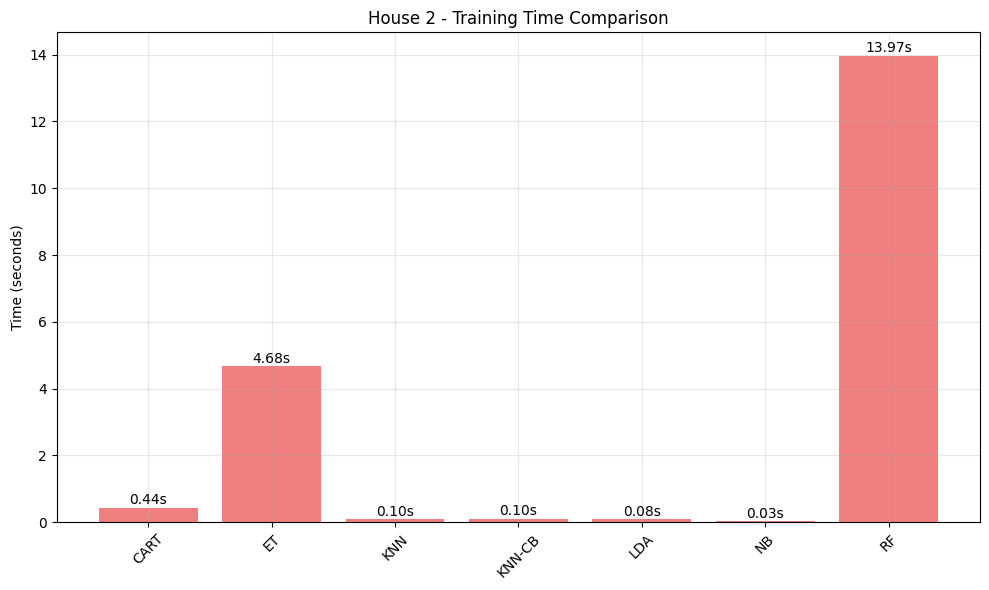


HOUSE 2 PERFORMANCE SUMMARY
Classifier   Accuracy   Macro F1   Weighted F1  Time (s)  
--------------------------------------------------------------------------------
CART         0.7838     0.3459     0.7552       0.44      
ET           0.7849     0.3459     0.7562       4.68      
KNN          0.7795     0.3210     0.7540       0.10      
KNN-CB       0.7891     0.3585     0.7617       0.10      
LDA          0.6904     0.0798     0.5859       0.08      
NB           0.6818     0.0789     0.5896       0.03      
RF           0.7854     0.3361     0.7563       13.97     

Results saved to: /kaggle/working/house2_results/house2_results_Th30_WindowingTrue.pkl

House 2 Configuration: With_Windowing, Threshold=40

################################################################################
HOUSE 2 EXPERIMENT: Threshold=40, Windowing=ON
################################################################################
Processing House 2
Selected 5 appliances: ['fridge', 'microwave', '

Loading CSV files:   0%|          | 0/7 [00:00<?, ?it/s]

First file columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']
Available appliances: ['fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']


Loading CSV files: 100%|██████████| 7/7 [00:00<00:00, 42.94it/s]



Loaded 292,063 samples from House 2
Available columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']

Data Statistics:
Column               Min        Max        Mean       Std        % Non-zero
--------------------------------------------------------------------------------
main                 36.36      3232.98    236.19     265.98     100.0     
fridge               0.00       2246.00    81.72      88.50      100.0     
microwave            0.00       1956.00    16.39      117.73     100.0     
washer_dryer         0.00       55.00      2.19       0.72       98.8      
dish_washer          0.00       1457.00    10.78      105.10     8.8       
electric_stove       0.00       457.00     1.62       20.73      48.8      

Applying Power Windowing (Paper Table 3 Methodology)

fridge              : Window [  50W,  200W]
  Before: 292,052 ON (100.0%)
  After:  127,917 ON ( 43.8%)
  Changed: 164,135 instances

microwave           : Window [  20W, 1650W]

Training classifiers:   0%|          | 0/7 [00:00<?, ?it/s]


Training CART...


Training classifiers:  14%|█▍        | 1/7 [00:00<00:03,  1.67it/s]

 ✓ Trained in 0.43s
   Macro F1: 0.3607
   Weighted F1: 0.7549
   Accuracy: 0.7834

Training ET...


Training classifiers:  29%|██▊       | 2/7 [00:06<00:17,  3.57s/it]

 ✓ Trained in 4.73s
   Macro F1: 0.3644
   Weighted F1: 0.7560
   Accuracy: 0.7846

Training KNN...


Training classifiers:  43%|████▎     | 3/7 [00:08<00:12,  3.11s/it]

 ✓ Trained in 0.10s
   Macro F1: 0.3353
   Weighted F1: 0.7542
   Accuracy: 0.7802

Training KNN-CB...


Training classifiers:  57%|█████▋    | 4/7 [00:09<00:06,  2.17s/it]

 ✓ Trained in 0.10s
   Macro F1: 0.3748
   Weighted F1: 0.7589
   Accuracy: 0.7852

Training LDA...


Training classifiers:  86%|████████▌ | 6/7 [00:09<00:01,  1.03s/it]

 ✓ Trained in 0.08s
   Macro F1: 0.0836
   Weighted F1: 0.5860
   Accuracy: 0.6905

Training NB...
 ✓ Trained in 0.03s
   Macro F1: 0.0827
   Weighted F1: 0.5898
   Accuracy: 0.6819

Training RF...


Training classifiers: 100%|██████████| 7/7 [00:24<00:00,  3.52s/it]

 ✓ Trained in 13.81s
   Macro F1: 0.3492
   Weighted F1: 0.7558
   Accuracy: 0.7848


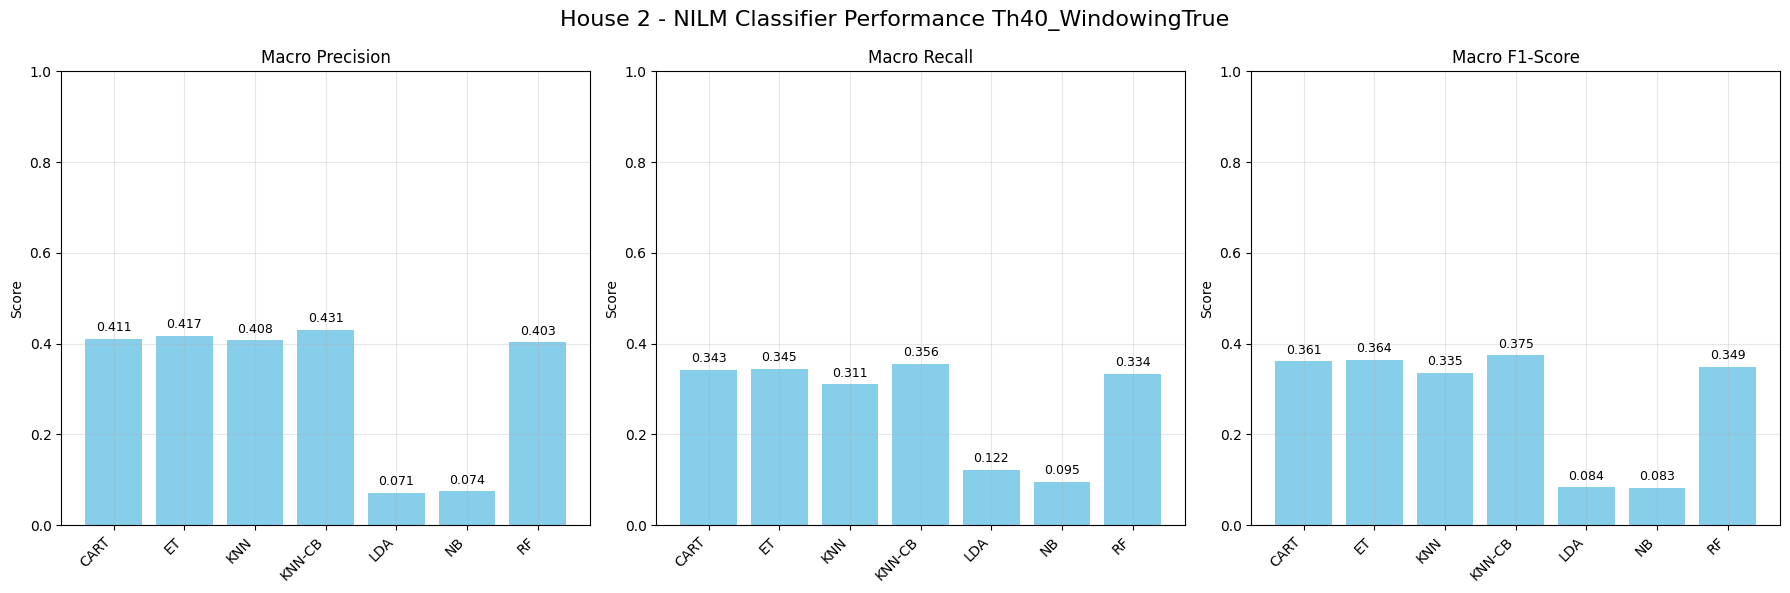

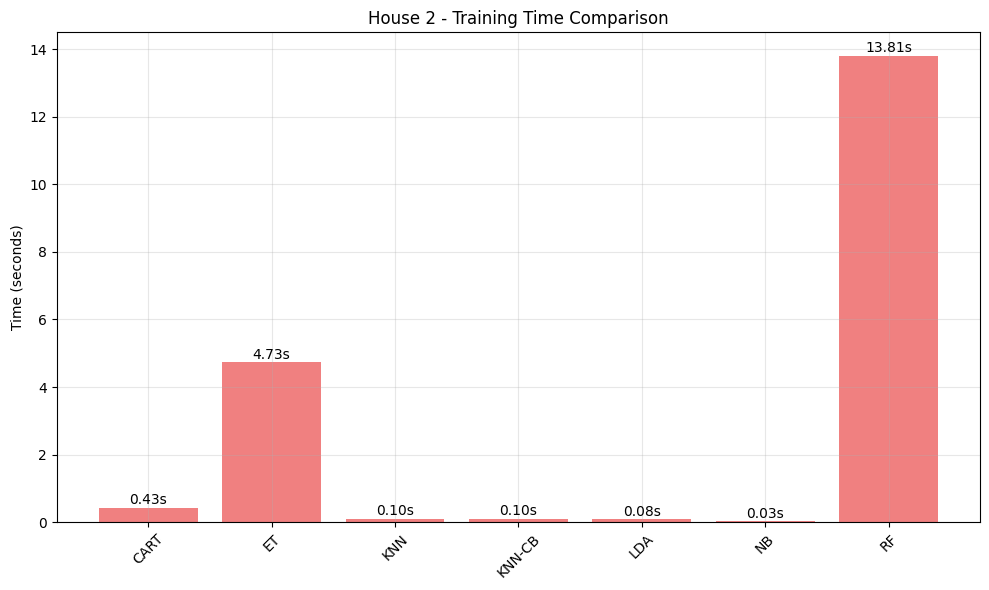


HOUSE 2 PERFORMANCE SUMMARY
Classifier   Accuracy   Macro F1   Weighted F1  Time (s)  
--------------------------------------------------------------------------------
CART         0.7834     0.3607     0.7549       0.43      
ET           0.7846     0.3644     0.7560       4.73      
KNN          0.7802     0.3353     0.7542       0.10      
KNN-CB       0.7852     0.3748     0.7589       0.10      
LDA          0.6905     0.0836     0.5860       0.08      
NB           0.6819     0.0827     0.5898       0.03      
RF           0.7848     0.3492     0.7558       13.81     

Results saved to: /kaggle/working/house2_results/house2_results_Th40_WindowingTrue.pkl

House 2 Configuration: With_Windowing, Threshold=50

################################################################################
HOUSE 2 EXPERIMENT: Threshold=50, Windowing=ON
################################################################################
Processing House 2
Selected 5 appliances: ['fridge', 'microwave', '

Loading CSV files:   0%|          | 0/7 [00:00<?, ?it/s]

First file columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']
Available appliances: ['fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']


Loading CSV files: 100%|██████████| 7/7 [00:00<00:00, 42.44it/s]



Loaded 292,063 samples from House 2
Available columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']

Data Statistics:
Column               Min        Max        Mean       Std        % Non-zero
--------------------------------------------------------------------------------
main                 36.36      3232.98    236.19     265.98     100.0     
fridge               0.00       2246.00    81.72      88.50      100.0     
microwave            0.00       1956.00    16.39      117.73     100.0     
washer_dryer         0.00       55.00      2.19       0.72       98.8      
dish_washer          0.00       1457.00    10.78      105.10     8.8       
electric_stove       0.00       457.00     1.62       20.73      48.8      

Applying Power Windowing (Paper Table 3 Methodology)

fridge              : Window [  50W,  200W]
  Before: 292,052 ON (100.0%)
  After:  127,917 ON ( 43.8%)
  Changed: 164,135 instances

microwave           : Window [  20W, 1650W]

Training classifiers:   0%|          | 0/7 [00:00<?, ?it/s]


Training CART...


Training classifiers:  14%|█▍        | 1/7 [00:00<00:03,  1.69it/s]

 ✓ Trained in 0.43s
   Macro F1: 0.3586
   Weighted F1: 0.7547
   Accuracy: 0.7833

Training ET...


Training classifiers:  29%|██▊       | 2/7 [00:06<00:17,  3.48s/it]

 ✓ Trained in 4.64s
   Macro F1: 0.3607
   Weighted F1: 0.7557
   Accuracy: 0.7844

Training KNN...


Training classifiers:  43%|████▎     | 3/7 [00:08<00:12,  3.05s/it]

 ✓ Trained in 0.10s
   Macro F1: 0.3501
   Weighted F1: 0.7549
   Accuracy: 0.7799

Training KNN-CB...


Training classifiers:  57%|█████▋    | 4/7 [00:09<00:06,  2.12s/it]

 ✓ Trained in 0.10s
   Macro F1: 0.3780
   Weighted F1: 0.7612
   Accuracy: 0.7884

Training LDA...


Training classifiers:  86%|████████▌ | 6/7 [00:09<00:01,  1.00s/it]

 ✓ Trained in 0.09s
   Macro F1: 0.0925
   Weighted F1: 0.5863
   Accuracy: 0.6908

Training NB...
 ✓ Trained in 0.03s
   Macro F1: 0.0913
   Weighted F1: 0.5898
   Accuracy: 0.6820

Training RF...


Training classifiers: 100%|██████████| 7/7 [00:24<00:00,  3.48s/it]

 ✓ Trained in 13.83s
   Macro F1: 0.3562
   Weighted F1: 0.7566
   Accuracy: 0.7854


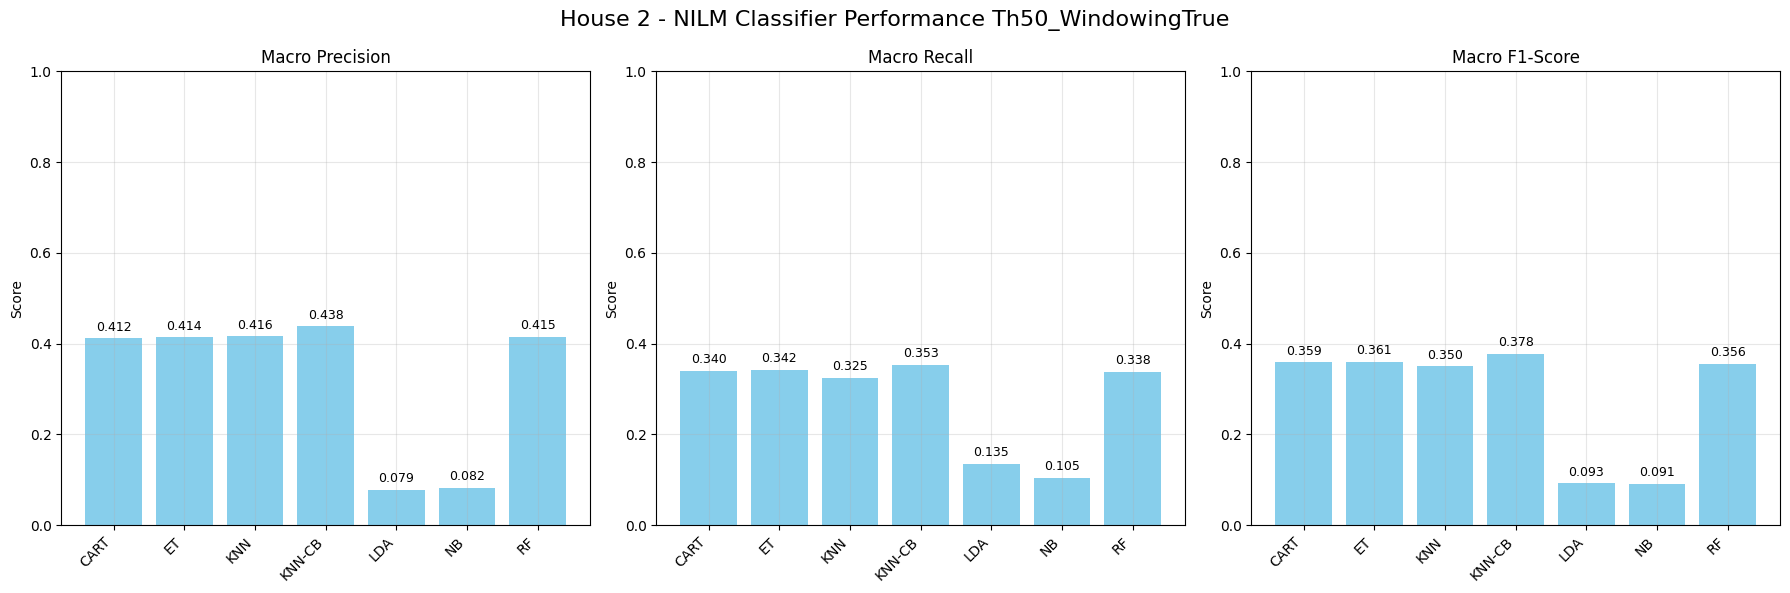

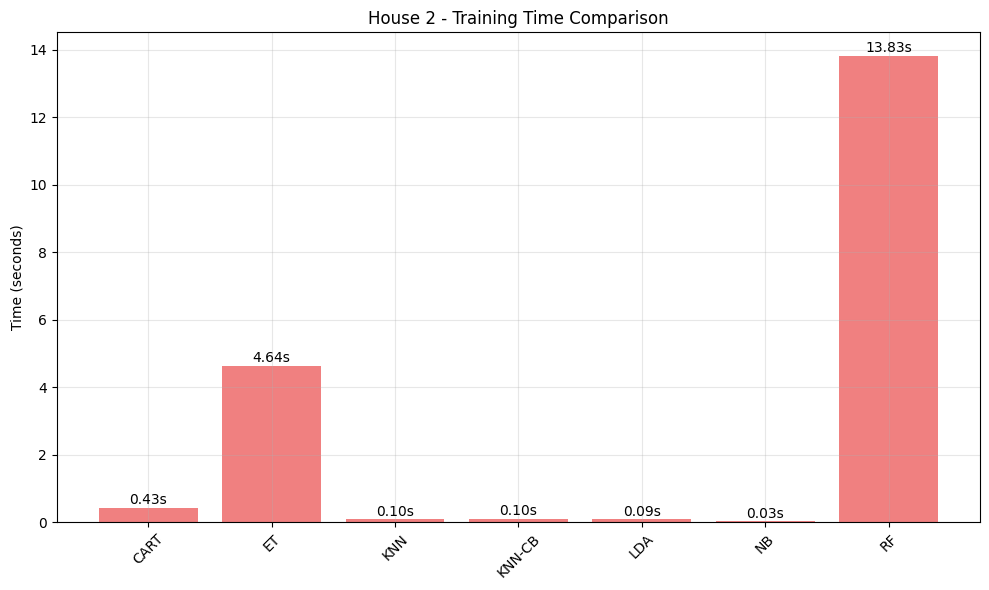


HOUSE 2 PERFORMANCE SUMMARY
Classifier   Accuracy   Macro F1   Weighted F1  Time (s)  
--------------------------------------------------------------------------------
CART         0.7833     0.3586     0.7547       0.43      
ET           0.7844     0.3607     0.7557       4.64      
KNN          0.7799     0.3501     0.7549       0.10      
KNN-CB       0.7884     0.3780     0.7612       0.10      
LDA          0.6908     0.0925     0.5863       0.09      
NB           0.6820     0.0913     0.5898       0.03      
RF           0.7854     0.3562     0.7566       13.83     

Results saved to: /kaggle/working/house2_results/house2_results_Th50_WindowingTrue.pkl

House 2 Configuration: Without_Windowing, Threshold=5

################################################################################
HOUSE 2 EXPERIMENT: Threshold=5, Windowing=OFF
################################################################################
Processing House 2
Selected 5 appliances: ['fridge', 'microwave',

Loading CSV files:  71%|███████▏  | 5/7 [00:00<00:00, 48.44it/s]

First file columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']
Available appliances: ['fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']


Loading CSV files: 100%|██████████| 7/7 [00:00<00:00, 40.27it/s]



Loaded 292,063 samples from House 2
Available columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']

Data Statistics:
Column               Min        Max        Mean       Std        % Non-zero
--------------------------------------------------------------------------------
main                 36.36      3232.98    236.19     265.98     100.0     
fridge               0.00       2246.00    81.72      88.50      100.0     
microwave            0.00       1956.00    16.39      117.73     100.0     
washer_dryer         0.00       55.00      2.19       0.72       98.8      
dish_washer          0.00       1457.00    10.78      105.10     8.8       
electric_stove       0.00       457.00     1.62       20.73      48.8      

Using binary labeling without power windowing (paper baseline)

Thresholding Analysis (Threshold = 5):
Total samples: 292,063
Unique combinations before thresholding: 12
Unique combinations after thresholding: 9
Samples after thres

Training classifiers:   0%|          | 0/7 [00:00<?, ?it/s]


Training CART...


Training classifiers:  14%|█▍        | 1/7 [00:00<00:03,  1.63it/s]

 ✓ Trained in 0.46s
   Macro F1: 0.3402
   Weighted F1: 0.7596
   Accuracy: 0.7793

Training ET...


Training classifiers:  29%|██▊       | 2/7 [00:05<00:16,  3.25s/it]

 ✓ Trained in 4.35s
   Macro F1: 0.3410
   Weighted F1: 0.7601
   Accuracy: 0.7799

Training KNN...


Training classifiers:  43%|████▎     | 3/7 [00:08<00:11,  2.94s/it]

 ✓ Trained in 0.09s
   Macro F1: 0.2448
   Weighted F1: 0.7516
   Accuracy: 0.7750

Training KNN-CB...


Training classifiers:  57%|█████▋    | 4/7 [00:08<00:06,  2.02s/it]

 ✓ Trained in 0.10s
   Macro F1: 0.3520
   Weighted F1: 0.7637
   Accuracy: 0.7830

Training LDA...


Training classifiers:  86%|████████▌ | 6/7 [00:09<00:00,  1.03it/s]

 ✓ Trained in 0.07s
   Macro F1: 0.1958
   Weighted F1: 0.7422
   Accuracy: 0.7757

Training NB...
 ✓ Trained in 0.02s
   Macro F1: 0.1966
   Weighted F1: 0.7398
   Accuracy: 0.7647

Training RF...


Training classifiers: 100%|██████████| 7/7 [00:24<00:00,  3.50s/it]

 ✓ Trained in 14.48s
   Macro F1: 0.3352
   Weighted F1: 0.7599
   Accuracy: 0.7796


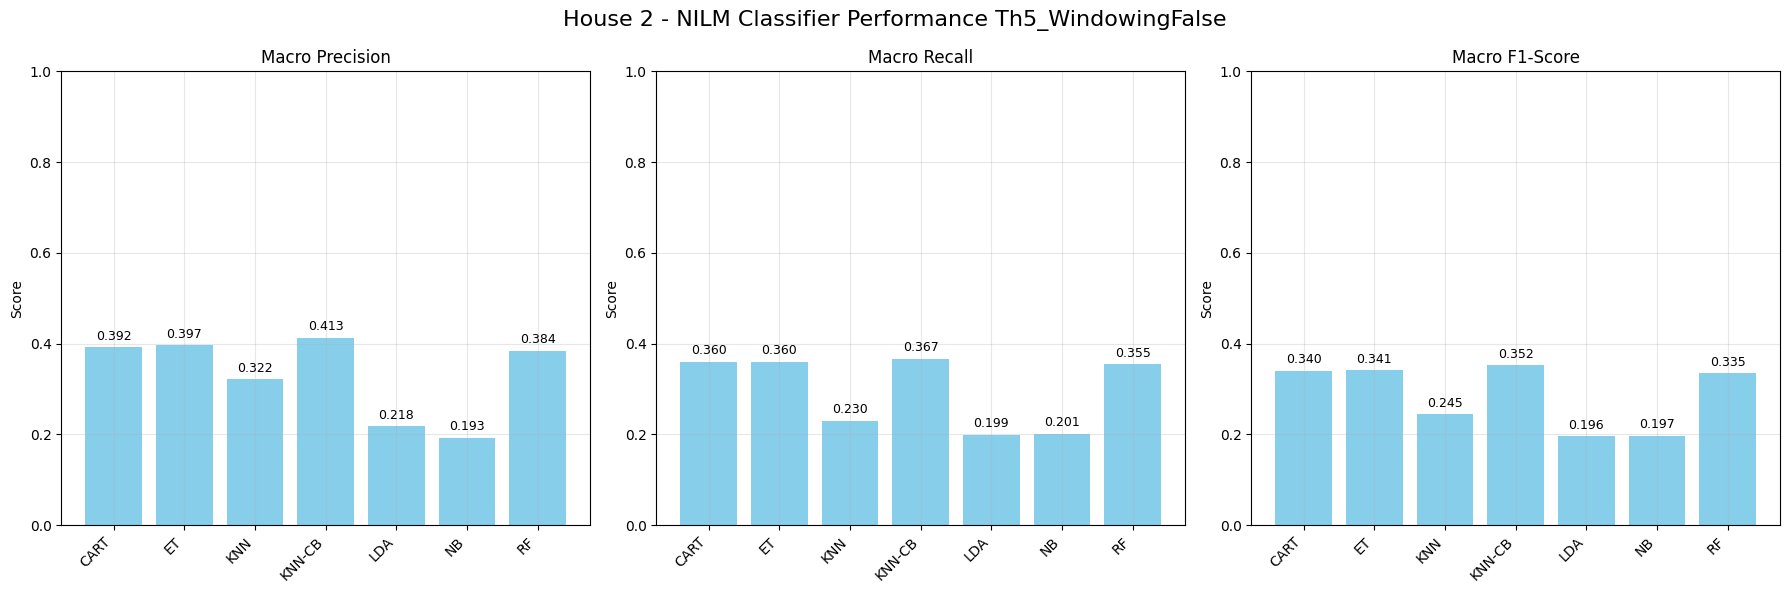

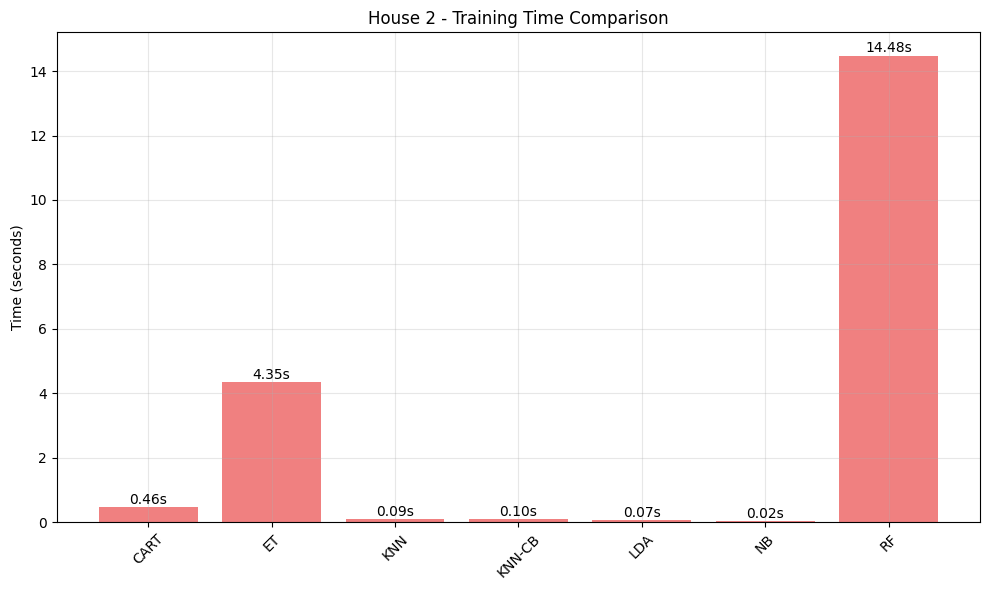


HOUSE 2 PERFORMANCE SUMMARY
Classifier   Accuracy   Macro F1   Weighted F1  Time (s)  
--------------------------------------------------------------------------------
CART         0.7793     0.3402     0.7596       0.46      
ET           0.7799     0.3410     0.7601       4.35      
KNN          0.7750     0.2448     0.7516       0.09      
KNN-CB       0.7830     0.3520     0.7637       0.10      
LDA          0.7757     0.1958     0.7422       0.07      
NB           0.7647     0.1966     0.7398       0.02      
RF           0.7796     0.3352     0.7599       14.48     

Results saved to: /kaggle/working/house2_results/house2_results_Th5_WindowingFalse.pkl

House 2 Configuration: Without_Windowing, Threshold=10

################################################################################
HOUSE 2 EXPERIMENT: Threshold=10, Windowing=OFF
################################################################################
Processing House 2
Selected 5 appliances: ['fridge', 'microwave

Loading CSV files:  71%|███████▏  | 5/7 [00:00<00:00, 48.14it/s]

First file columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']
Available appliances: ['fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']


Loading CSV files: 100%|██████████| 7/7 [00:00<00:00, 40.36it/s]



Loaded 292,063 samples from House 2
Available columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']

Data Statistics:
Column               Min        Max        Mean       Std        % Non-zero
--------------------------------------------------------------------------------
main                 36.36      3232.98    236.19     265.98     100.0     
fridge               0.00       2246.00    81.72      88.50      100.0     
microwave            0.00       1956.00    16.39      117.73     100.0     
washer_dryer         0.00       55.00      2.19       0.72       98.8      
dish_washer          0.00       1457.00    10.78      105.10     8.8       
electric_stove       0.00       457.00     1.62       20.73      48.8      

Using binary labeling without power windowing (paper baseline)

Thresholding Analysis (Threshold = 10):
Total samples: 292,063
Unique combinations before thresholding: 12
Unique combinations after thresholding: 8
Samples after thre

Training classifiers:   0%|          | 0/7 [00:00<?, ?it/s]


Training CART...


Training classifiers:  14%|█▍        | 1/7 [00:00<00:03,  1.59it/s]

 ✓ Trained in 0.48s
   Macro F1: 0.3139
   Weighted F1: 0.7601
   Accuracy: 0.7796

Training ET...


Training classifiers:  29%|██▊       | 2/7 [00:05<00:15,  3.18s/it]

 ✓ Trained in 4.26s
   Macro F1: 0.3153
   Weighted F1: 0.7608
   Accuracy: 0.7806

Training KNN...


Training classifiers:  43%|████▎     | 3/7 [00:08<00:11,  2.88s/it]

 ✓ Trained in 0.09s
   Macro F1: 0.2668
   Weighted F1: 0.7498
   Accuracy: 0.7733

Training KNN-CB...


Training classifiers:  57%|█████▋    | 4/7 [00:08<00:06,  2.00s/it]

 ✓ Trained in 0.10s
   Macro F1: 0.3269
   Weighted F1: 0.7644
   Accuracy: 0.7836

Training LDA...


Training classifiers:  86%|████████▌ | 6/7 [00:09<00:00,  1.04it/s]

 ✓ Trained in 0.07s
   Macro F1: 0.2194
   Weighted F1: 0.7422
   Accuracy: 0.7761

Training NB...
 ✓ Trained in 0.02s
   Macro F1: 0.2212
   Weighted F1: 0.7400
   Accuracy: 0.7651

Training RF...


Training classifiers: 100%|██████████| 7/7 [00:23<00:00,  3.43s/it]

 ✓ Trained in 14.14s
   Macro F1: 0.3096
   Weighted F1: 0.7605
   Accuracy: 0.7798


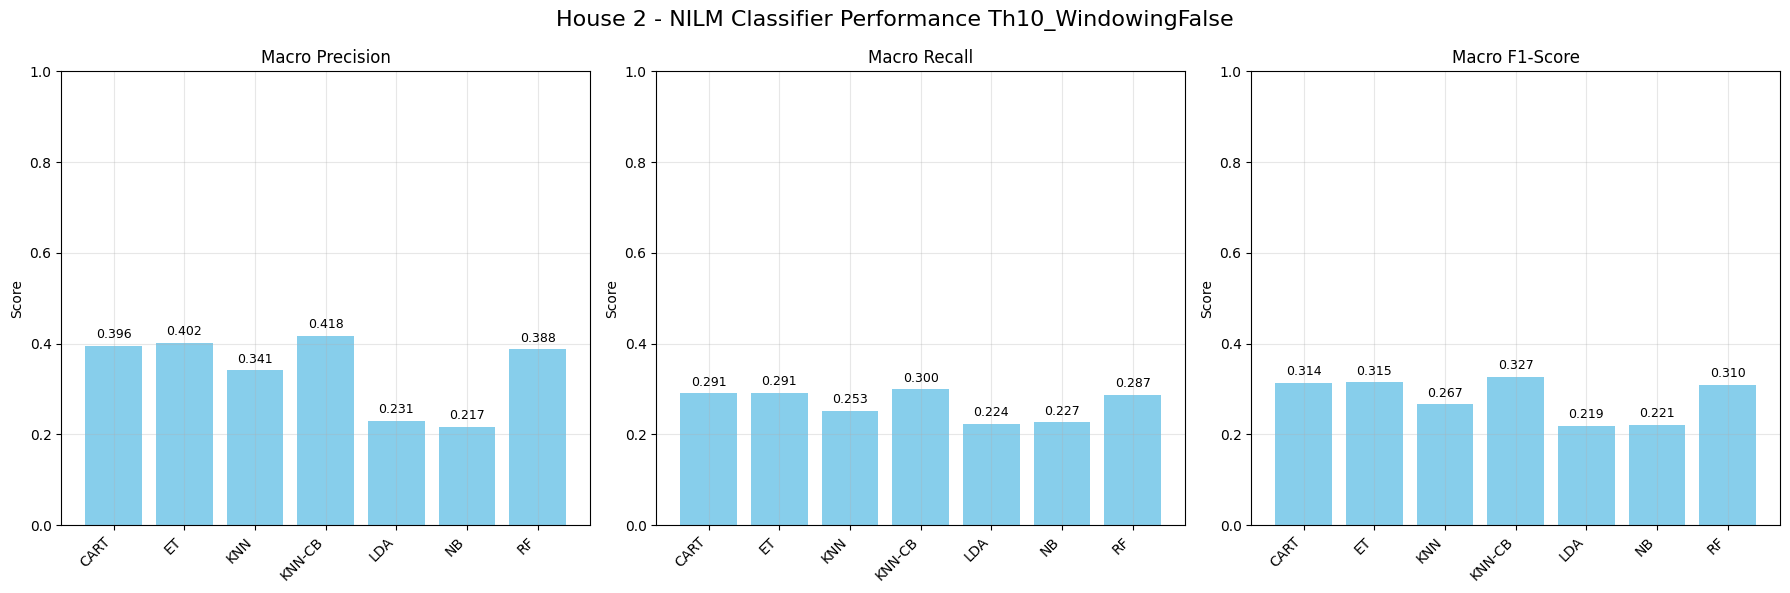

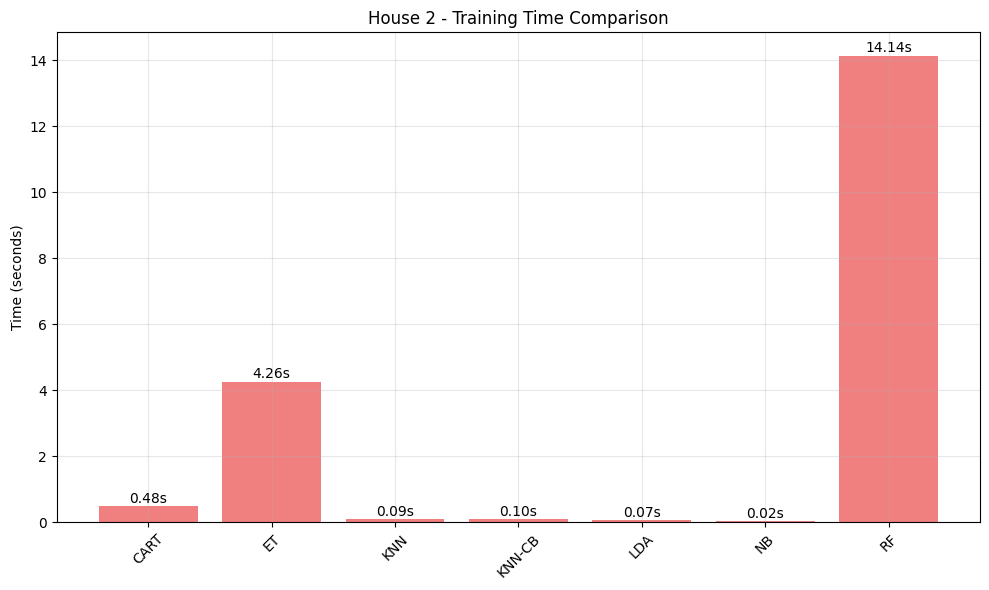


HOUSE 2 PERFORMANCE SUMMARY
Classifier   Accuracy   Macro F1   Weighted F1  Time (s)  
--------------------------------------------------------------------------------
CART         0.7796     0.3139     0.7601       0.48      
ET           0.7806     0.3153     0.7608       4.26      
KNN          0.7733     0.2668     0.7498       0.09      
KNN-CB       0.7836     0.3269     0.7644       0.10      
LDA          0.7761     0.2194     0.7422       0.07      
NB           0.7651     0.2212     0.7400       0.02      
RF           0.7798     0.3096     0.7605       14.14     

Results saved to: /kaggle/working/house2_results/house2_results_Th10_WindowingFalse.pkl

House 2 Configuration: Without_Windowing, Threshold=20

################################################################################
HOUSE 2 EXPERIMENT: Threshold=20, Windowing=OFF
################################################################################
Processing House 2
Selected 5 appliances: ['fridge', 'microwav

Loading CSV files:  86%|████████▌ | 6/7 [00:00<00:00, 40.03it/s]

First file columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']
Available appliances: ['fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']


Loading CSV files: 100%|██████████| 7/7 [00:00<00:00, 42.39it/s]



Loaded 292,063 samples from House 2
Available columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']

Data Statistics:
Column               Min        Max        Mean       Std        % Non-zero
--------------------------------------------------------------------------------
main                 36.36      3232.98    236.19     265.98     100.0     
fridge               0.00       2246.00    81.72      88.50      100.0     
microwave            0.00       1956.00    16.39      117.73     100.0     
washer_dryer         0.00       55.00      2.19       0.72       98.8      
dish_washer          0.00       1457.00    10.78      105.10     8.8       
electric_stove       0.00       457.00     1.62       20.73      48.8      

Using binary labeling without power windowing (paper baseline)

Thresholding Analysis (Threshold = 20):
Total samples: 292,063
Unique combinations before thresholding: 12
Unique combinations after thresholding: 8
Samples after thre

Training classifiers:   0%|          | 0/7 [00:00<?, ?it/s]


Training CART...


Training classifiers:  14%|█▍        | 1/7 [00:00<00:03,  1.68it/s]

 ✓ Trained in 0.45s
   Macro F1: 0.3139
   Weighted F1: 0.7601
   Accuracy: 0.7796

Training ET...


Training classifiers:  29%|██▊       | 2/7 [00:05<00:15,  3.11s/it]

 ✓ Trained in 4.18s
   Macro F1: 0.3153
   Weighted F1: 0.7608
   Accuracy: 0.7806

Training KNN...


Training classifiers:  43%|████▎     | 3/7 [00:07<00:11,  2.84s/it]

 ✓ Trained in 0.09s
   Macro F1: 0.2668
   Weighted F1: 0.7498
   Accuracy: 0.7733

Training KNN-CB...


Training classifiers:  57%|█████▋    | 4/7 [00:08<00:05,  1.93s/it]

 ✓ Trained in 0.10s
   Macro F1: 0.3269
   Weighted F1: 0.7644
   Accuracy: 0.7836

Training LDA...


Training classifiers:  86%|████████▌ | 6/7 [00:08<00:00,  1.08it/s]

 ✓ Trained in 0.07s
   Macro F1: 0.2194
   Weighted F1: 0.7422
   Accuracy: 0.7761

Training NB...
 ✓ Trained in 0.02s
   Macro F1: 0.2212
   Weighted F1: 0.7400
   Accuracy: 0.7651

Training RF...


Training classifiers: 100%|██████████| 7/7 [00:23<00:00,  3.43s/it]

 ✓ Trained in 14.41s
   Macro F1: 0.3096
   Weighted F1: 0.7605
   Accuracy: 0.7798


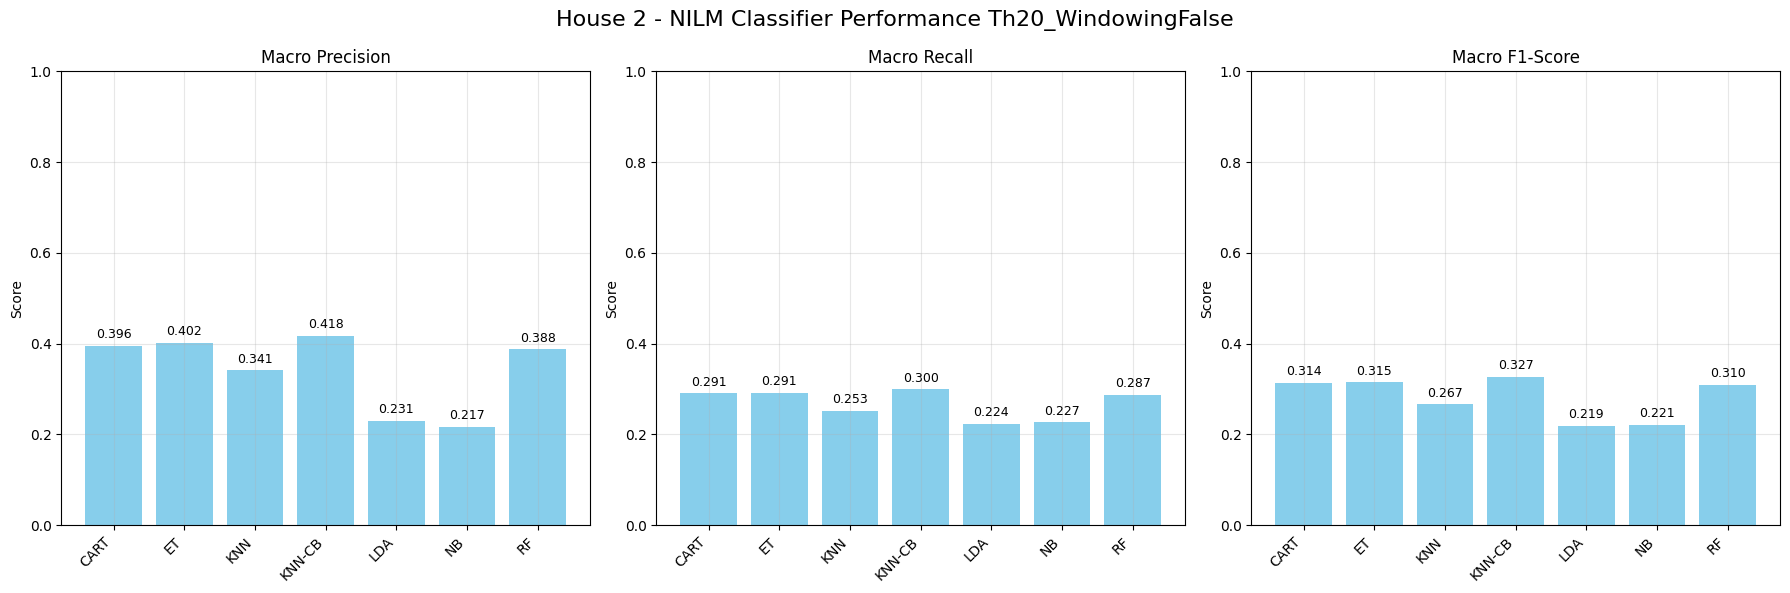

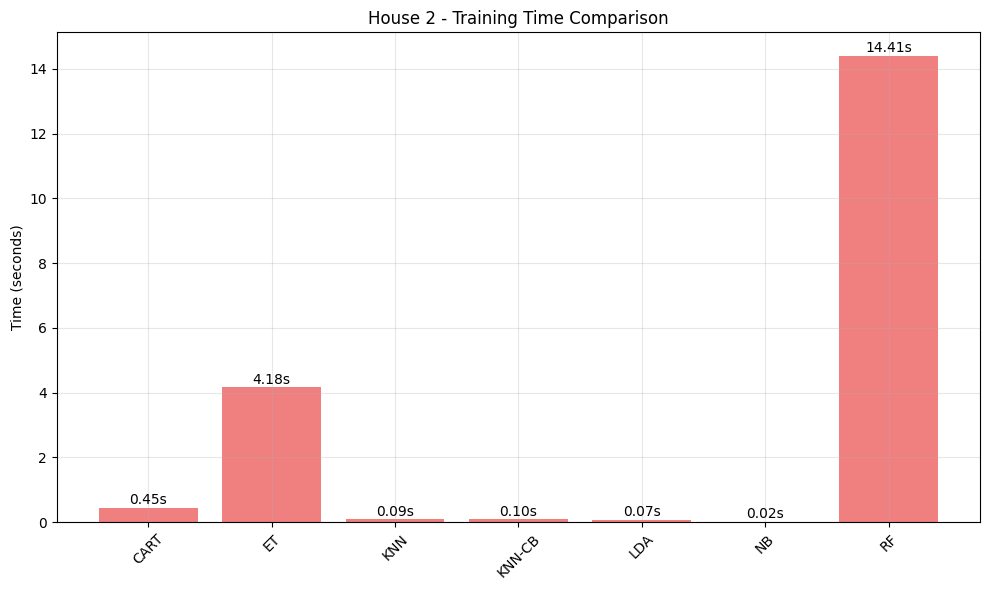


HOUSE 2 PERFORMANCE SUMMARY
Classifier   Accuracy   Macro F1   Weighted F1  Time (s)  
--------------------------------------------------------------------------------
CART         0.7796     0.3139     0.7601       0.45      
ET           0.7806     0.3153     0.7608       4.18      
KNN          0.7733     0.2668     0.7498       0.09      
KNN-CB       0.7836     0.3269     0.7644       0.10      
LDA          0.7761     0.2194     0.7422       0.07      
NB           0.7651     0.2212     0.7400       0.02      
RF           0.7798     0.3096     0.7605       14.41     

Results saved to: /kaggle/working/house2_results/house2_results_Th20_WindowingFalse.pkl

House 2 Configuration: Without_Windowing, Threshold=30

################################################################################
HOUSE 2 EXPERIMENT: Threshold=30, Windowing=OFF
################################################################################
Processing House 2
Selected 5 appliances: ['fridge', 'microwav

Loading CSV files: 100%|██████████| 7/7 [00:00<00:00, 41.79it/s]

First file columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']
Available appliances: ['fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']

Loaded 292,063 samples from House 2
Available columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']

Data Statistics:
Column               Min        Max        Mean       Std        % Non-zero
--------------------------------------------------------------------------------


main                 36.36      3232.98    236.19     265.98     100.0     
fridge               0.00       2246.00    81.72      88.50      100.0     
microwave            0.00       1956.00    16.39      117.73     100.0     
washer_dryer         0.00       55.00      2.19       0.72       98.8      
dish_washer          0.00       1457.00    10.78      105.10     8.8       
electric_stove       0.00       457.00     1.62       20.73      48.8      

Using binary labeling without power windowing (paper baseline)

Thresholding Analysis (Threshold = 30):
Total samples: 292,063
Unique combinations before thresholding: 12
Unique combinations after thresholding: 8
Samples after thresholding: 292,051 (100.0%)
Removed samples: 12

Top 10 appliance combinations:
 Combination: FRI|MIC|WAS|DIS|ELE
 00111 : FRI:0|MIC:0|WAS:1|DIS:1|ELE:1 : 132,844 occurrences
 01111 : FRI:0|MIC:1|WAS:1|DIS:1|ELE:1 : 129,934 occurrences
 10111 : FRI:1|MIC:0|WAS:1|DIS:1|ELE:1 :  13,443 occurrences
 11111 : FRI:1|M

Training classifiers:   0%|          | 0/7 [00:00<?, ?it/s]


Training CART...


Training classifiers:  14%|█▍        | 1/7 [00:00<00:03,  1.61it/s]

 ✓ Trained in 0.47s
   Macro F1: 0.3139
   Weighted F1: 0.7601
   Accuracy: 0.7796

Training ET...


Training classifiers:  29%|██▊       | 2/7 [00:05<00:15,  3.14s/it]

 ✓ Trained in 4.20s
   Macro F1: 0.3153
   Weighted F1: 0.7608
   Accuracy: 0.7806

Training KNN...


Training classifiers:  43%|████▎     | 3/7 [00:08<00:11,  2.89s/it]

 ✓ Trained in 0.10s
   Macro F1: 0.2668
   Weighted F1: 0.7498
   Accuracy: 0.7733

Training KNN-CB...


Training classifiers:  57%|█████▋    | 4/7 [00:08<00:05,  1.96s/it]

 ✓ Trained in 0.10s
   Macro F1: 0.3269
   Weighted F1: 0.7644
   Accuracy: 0.7836

Training LDA...


Training classifiers:  86%|████████▌ | 6/7 [00:09<00:00,  1.06it/s]

 ✓ Trained in 0.07s
   Macro F1: 0.2194
   Weighted F1: 0.7422
   Accuracy: 0.7761

Training NB...
 ✓ Trained in 0.02s
   Macro F1: 0.2212
   Weighted F1: 0.7400
   Accuracy: 0.7651

Training RF...


Training classifiers: 100%|██████████| 7/7 [00:23<00:00,  3.39s/it]

 ✓ Trained in 14.02s
   Macro F1: 0.3096
   Weighted F1: 0.7605
   Accuracy: 0.7798


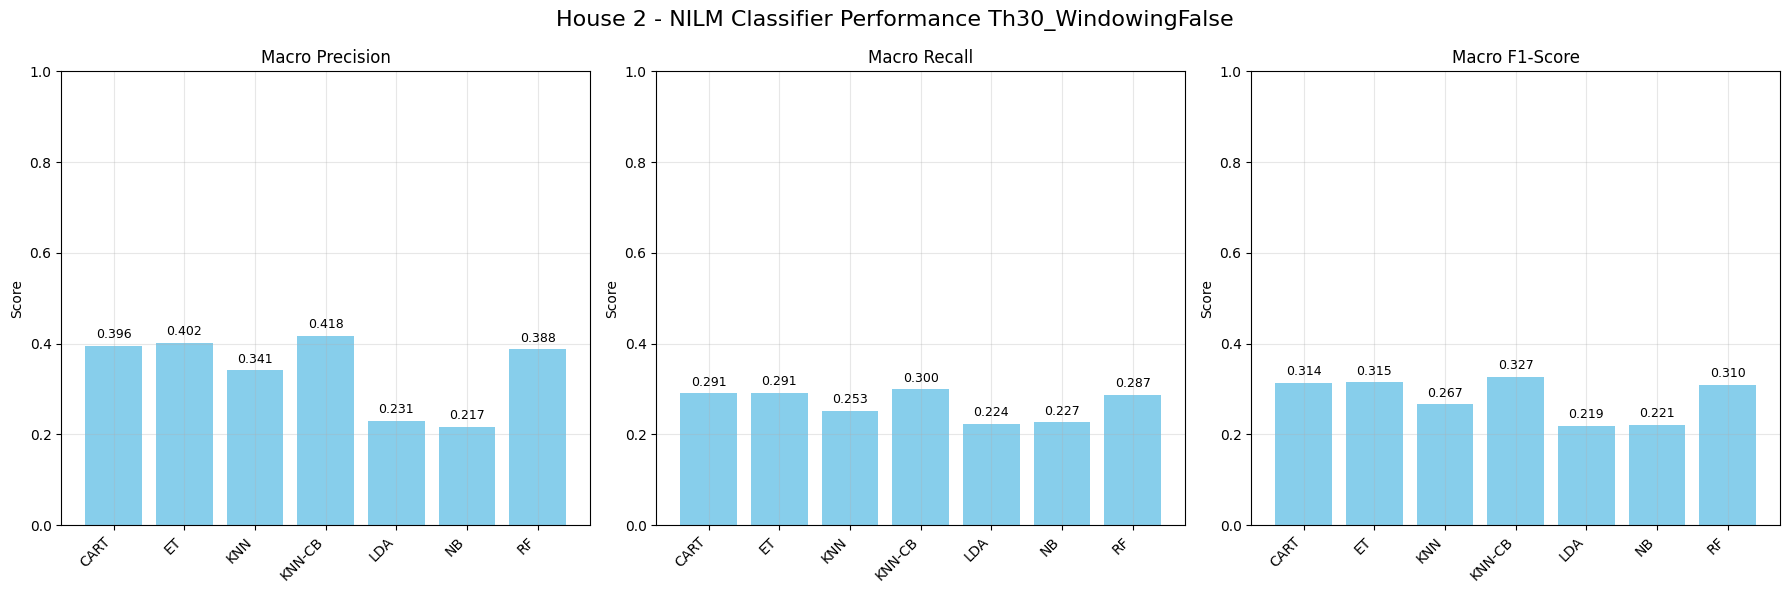

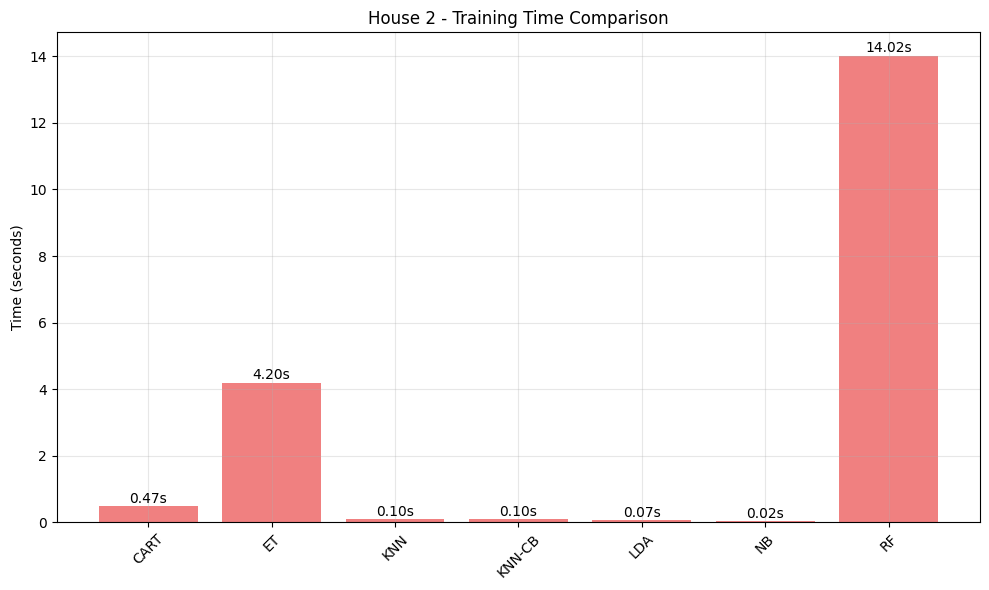


HOUSE 2 PERFORMANCE SUMMARY
Classifier   Accuracy   Macro F1   Weighted F1  Time (s)  
--------------------------------------------------------------------------------
CART         0.7796     0.3139     0.7601       0.47      
ET           0.7806     0.3153     0.7608       4.20      
KNN          0.7733     0.2668     0.7498       0.10      
KNN-CB       0.7836     0.3269     0.7644       0.10      
LDA          0.7761     0.2194     0.7422       0.07      
NB           0.7651     0.2212     0.7400       0.02      
RF           0.7798     0.3096     0.7605       14.02     

Results saved to: /kaggle/working/house2_results/house2_results_Th30_WindowingFalse.pkl

House 2 Configuration: Without_Windowing, Threshold=40

################################################################################
HOUSE 2 EXPERIMENT: Threshold=40, Windowing=OFF
################################################################################
Processing House 2
Selected 5 appliances: ['fridge', 'microwav

Loading CSV files: 100%|██████████| 7/7 [00:00<00:00, 41.06it/s]

First file columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']
Available appliances: ['fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']



Loaded 292,063 samples from House 2
Available columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']

Data Statistics:
Column               Min        Max        Mean       Std        % Non-zero
--------------------------------------------------------------------------------
main                 36.36      3232.98    236.19     265.98     100.0     
fridge               0.00       2246.00    81.72      88.50      100.0     
microwave            0.00       1956.00    16.39      117.73     100.0     
washer_dryer         0.00       55.00      2.19       0.72       98.8      
dish_washer          0.00       1457.00    10.78      105.10     8.8       
electric_stove       0.00       457.00     1.62       20.73      48.8      

Using binary labeling without power windowing (paper baseline)

Thresholding Analysis (Threshold = 40):
Total samples: 292,063
Unique combinations before thresholding: 12
Unique combinations after thresholding: 7
Samples after thre

Training classifiers:   0%|          | 0/7 [00:00<?, ?it/s]


Training CART...


Training classifiers:  14%|█▍        | 1/7 [00:00<00:03,  1.63it/s]

 ✓ Trained in 0.46s
   Macro F1: 0.3599
   Weighted F1: 0.7605
   Accuracy: 0.7799

Training ET...


Training classifiers:  29%|██▊       | 2/7 [00:05<00:15,  3.12s/it]

 ✓ Trained in 4.18s
   Macro F1: 0.3619
   Weighted F1: 0.7611
   Accuracy: 0.7808

Training KNN...


Training classifiers:  43%|████▎     | 3/7 [00:07<00:11,  2.82s/it]

 ✓ Trained in 0.09s
   Macro F1: 0.3136
   Weighted F1: 0.7518
   Accuracy: 0.7749

Training KNN-CB...


Training classifiers:  71%|███████▏  | 5/7 [00:08<00:02,  1.33s/it]

 ✓ Trained in 0.09s
   Macro F1: 0.3747
   Weighted F1: 0.7646
   Accuracy: 0.7837

Training LDA...
 ✓ Trained in 0.07s
   Macro F1: 0.2507
   Weighted F1: 0.7423
   Accuracy: 0.7762

Training NB...


Training classifiers:  86%|████████▌ | 6/7 [00:08<00:00,  1.09it/s]

 ✓ Trained in 0.02s
   Macro F1: 0.2528
   Weighted F1: 0.7402
   Accuracy: 0.7652

Training RF...


Training classifiers: 100%|██████████| 7/7 [00:23<00:00,  3.38s/it]

 ✓ Trained in 14.03s
   Macro F1: 0.3510
   Weighted F1: 0.7605
   Accuracy: 0.7798


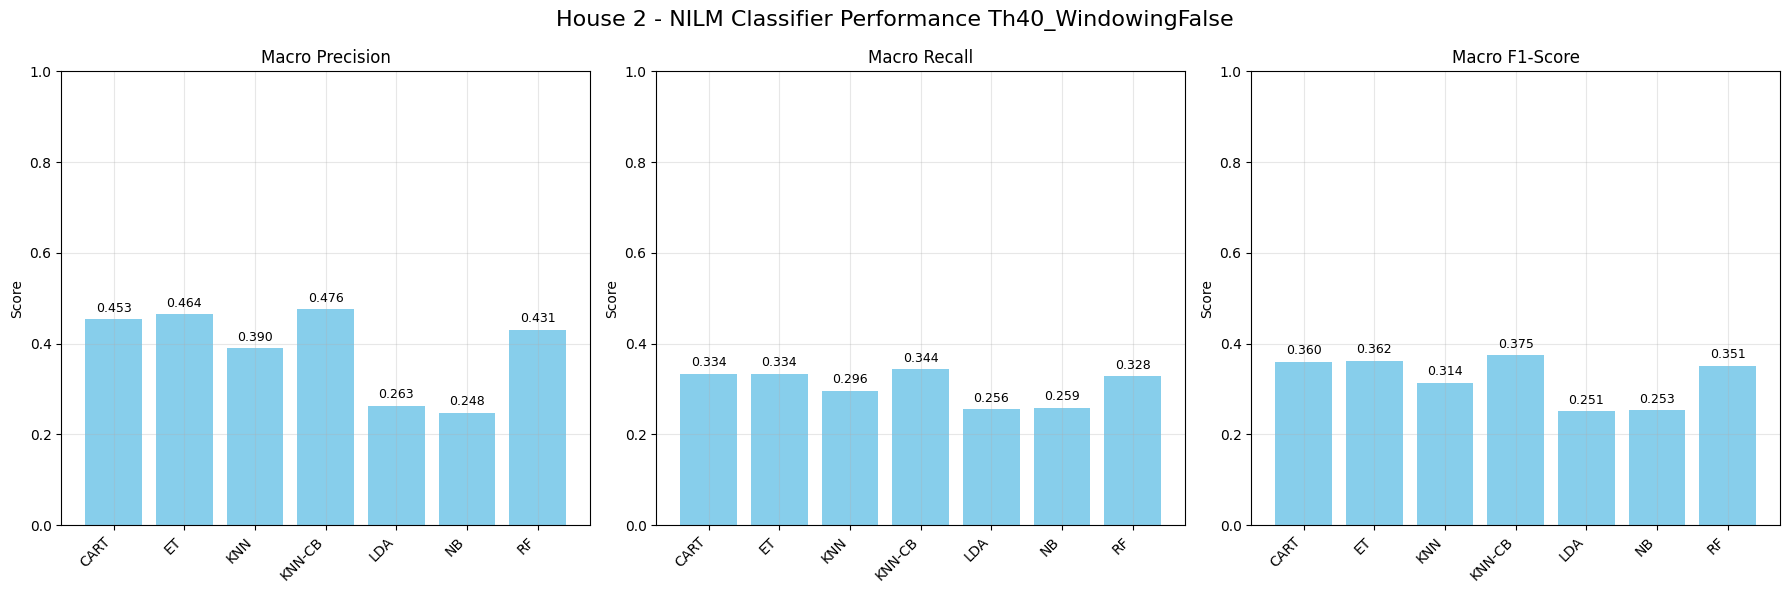

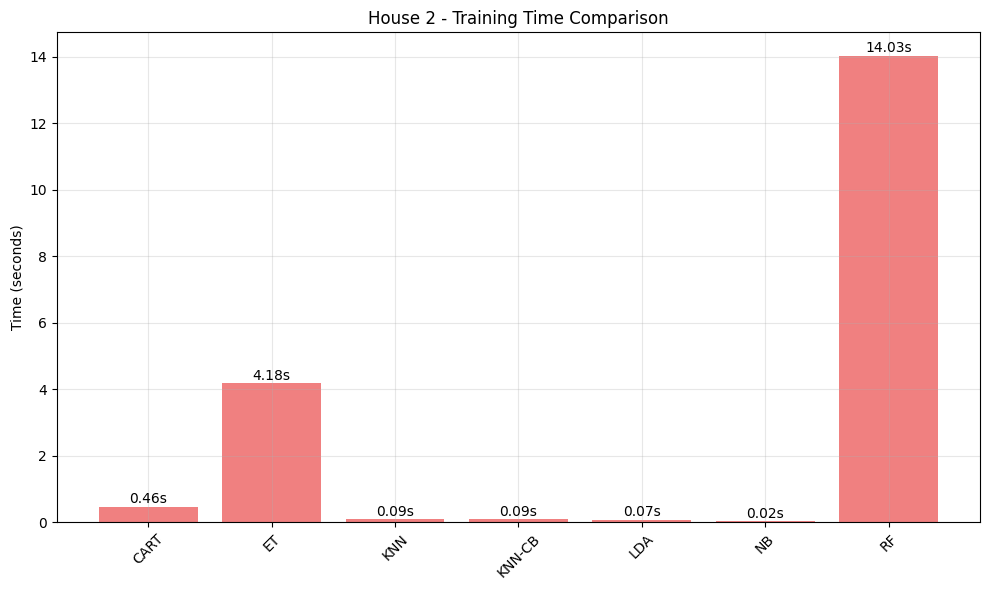


HOUSE 2 PERFORMANCE SUMMARY
Classifier   Accuracy   Macro F1   Weighted F1  Time (s)  
--------------------------------------------------------------------------------
CART         0.7799     0.3599     0.7605       0.46      
ET           0.7808     0.3619     0.7611       4.18      
KNN          0.7749     0.3136     0.7518       0.09      
KNN-CB       0.7837     0.3747     0.7646       0.09      
LDA          0.7762     0.2507     0.7423       0.07      
NB           0.7652     0.2528     0.7402       0.02      
RF           0.7798     0.3510     0.7605       14.03     

Results saved to: /kaggle/working/house2_results/house2_results_Th40_WindowingFalse.pkl

House 2 Configuration: Without_Windowing, Threshold=50

################################################################################
HOUSE 2 EXPERIMENT: Threshold=50, Windowing=OFF
################################################################################
Processing House 2
Selected 5 appliances: ['fridge', 'microwav

Loading CSV files: 100%|██████████| 7/7 [00:00<00:00, 40.72it/s]

First file columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']
Available appliances: ['fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']

Loaded 292,063 samples from House 2
Available columns: ['main', 'fridge', 'microwave', 'washer_dryer', 'dish_washer', 'electric_stove']

Data Statistics:
Column               Min        Max        Mean       Std        % Non-zero
--------------------------------------------------------------------------------


main                 36.36      3232.98    236.19     265.98     100.0     
fridge               0.00       2246.00    81.72      88.50      100.0     
microwave            0.00       1956.00    16.39      117.73     100.0     
washer_dryer         0.00       55.00      2.19       0.72       98.8      
dish_washer          0.00       1457.00    10.78      105.10     8.8       
electric_stove       0.00       457.00     1.62       20.73      48.8      

Using binary labeling without power windowing (paper baseline)

Thresholding Analysis (Threshold = 50):
Total samples: 292,063
Unique combinations before thresholding: 12
Unique combinations after thresholding: 7
Samples after thresholding: 292,018 (100.0%)
Removed samples: 45

Top 10 appliance combinations:
 Combination: FRI|MIC|WAS|DIS|ELE
 00111 : FRI:0|MIC:0|WAS:1|DIS:1|ELE:1 : 132,844 occurrences
 01111 : FRI:0|MIC:1|WAS:1|DIS:1|ELE:1 : 129,934 occurrences
 10111 : FRI:1|MIC:0|WAS:1|DIS:1|ELE:1 :  13,443 occurrences
 11111 : FRI:1|M

Training classifiers:   0%|          | 0/7 [00:00<?, ?it/s]


Training CART...


Training classifiers:  14%|█▍        | 1/7 [00:00<00:03,  1.65it/s]

 ✓ Trained in 0.46s
   Macro F1: 0.3599
   Weighted F1: 0.7605
   Accuracy: 0.7799

Training ET...


Training classifiers:  29%|██▊       | 2/7 [00:05<00:15,  3.16s/it]

 ✓ Trained in 4.23s
   Macro F1: 0.3619
   Weighted F1: 0.7611
   Accuracy: 0.7808

Training KNN...


Training classifiers:  43%|████▎     | 3/7 [00:08<00:11,  2.88s/it]

 ✓ Trained in 0.09s
   Macro F1: 0.3136
   Weighted F1: 0.7518
   Accuracy: 0.7749

Training KNN-CB...


Training classifiers:  71%|███████▏  | 5/7 [00:08<00:02,  1.32s/it]

 ✓ Trained in 0.09s
   Macro F1: 0.3747
   Weighted F1: 0.7646
   Accuracy: 0.7837

Training LDA...
 ✓ Trained in 0.08s
   Macro F1: 0.2507
   Weighted F1: 0.7423
   Accuracy: 0.7762

Training NB...


Training classifiers:  86%|████████▌ | 6/7 [00:08<00:00,  1.09it/s]

 ✓ Trained in 0.03s
   Macro F1: 0.2528
   Weighted F1: 0.7402
   Accuracy: 0.7652

Training RF...


Training classifiers: 100%|██████████| 7/7 [00:23<00:00,  3.38s/it]

 ✓ Trained in 14.06s
   Macro F1: 0.3510
   Weighted F1: 0.7605
   Accuracy: 0.7798


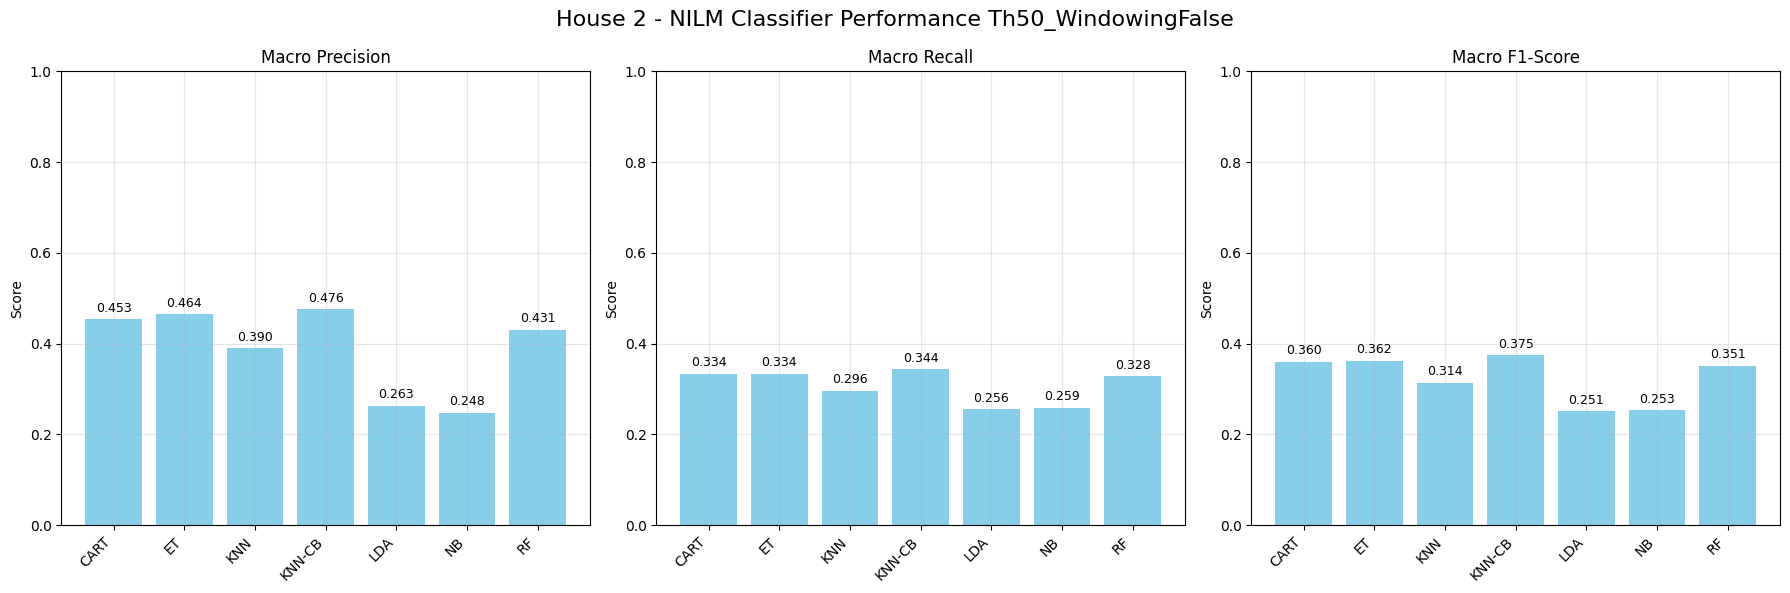

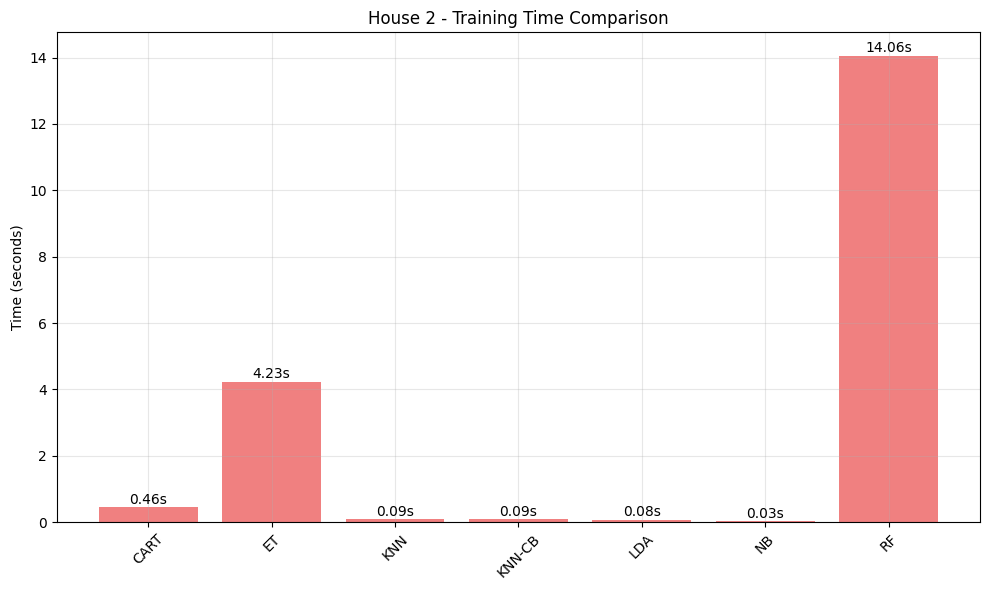


HOUSE 2 PERFORMANCE SUMMARY
Classifier   Accuracy   Macro F1   Weighted F1  Time (s)  
--------------------------------------------------------------------------------
CART         0.7799     0.3599     0.7605       0.46      
ET           0.7808     0.3619     0.7611       4.23      
KNN          0.7749     0.3136     0.7518       0.09      
KNN-CB       0.7837     0.3747     0.7646       0.09      
LDA          0.7762     0.2507     0.7423       0.08      
NB           0.7652     0.2528     0.7402       0.03      
RF           0.7798     0.3510     0.7605       14.06     

Results saved to: /kaggle/working/house2_results/house2_results_Th50_WindowingFalse.pkl

################################################################################
HOUSE 2 COMPREHENSIVE RESULTS SUMMARY
################################################################################

With_Windowing:
----------------------------------------
  Threshold  5: Best = KNN-CB  , Macro F1 = 0.3464, Classes =  23, Sam

In [1]:
"""
POWER PROFILE AND THRESHOLDING ASSISTED MULTI-LABEL NILM CLASSIFICATION

Paper Replication Code - HOUSE 2

Author: Research Replication Team
Date: 2024

This code faithfully replicates the methodology from the paper:
"Power Profile and Thresholding Assisted Multi-Label NILM Classification"

using the REDD dataset House 2 with available appliances.

Dataset path: /kaggle/input/redd-dataset/redd
"""

# ===================== SETUP AND CONFIGURATION =====================

import os
import sys
import numpy as np
import pandas as pd
import glob
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import joblib

# Set paths
DATA_PATH = "/kaggle/input/redd-dataset/redd"
OUTPUT_PATH = "/kaggle/working/house2_results/"

# Create output directory
os.makedirs(OUTPUT_PATH, exist_ok=True)

# ===================== HOUSE 2 SPECIFIC CONFIGURATION =====================

class ConfigHouse2:
    """House 2 specific configuration based on REDD dataset structure"""
    
    HOUSE_NUMBER = 2  # House 2
    
    # Channel mapping for House 2 based on actual data from output
    # From the output, we can see which appliances are actually available
    CHANNEL_MAP = {
        'fridge': 'channel_5',
        'microwave': 'channel_11',
        'washer_dryer': 'channel_10',
        'dish_washer': 'channel_6',
        'electric_stove': 'channel_14',
    }
    
    # Based on actual data availability from output
    # Only include appliances that are actually in the data
    # The output shows: fridge, microwave, washer_dryer, dish_washer, electric_stove are available
    # lighting and kitchen_outlet are NOT available (filled with zeros)
    SELECTED_APPLIANCES = [
        'fridge',
        'microwave',
        'washer_dryer',
        'dish_washer',
        'electric_stove',
    ]
    
    # Adjusted power windows based on actual data statistics from output
    # The original windows were too high for some appliances (e.g., washer_dryer max 55W but window 250-700)
    POWER_WINDOWS = {
        'dish_washer': (30, 1200),
        'fridge': (50, 200),      # Adjusted: original 175-500 was too high (mean 81.72)
        'microwave': (20, 1650),
        'washer_dryer': (1, 10),   # Adjusted: original 250-700 was too high (max 55, mean 2.19)
        'electric_stove': (1, 10), # Adjusted: original 1000-3500 was too high (max 457, mean 1.62)
    }
    
    # Threshold values (OPM) as in paper
    THRESHOLDS = [5, 10, 20, 30, 40, 50]
    
    # Experimental scenarios
    WINDOWING_SCENARIOS = [True, False]
    
    # Training parameters
    RANDOM_STATE = 42
    TEST_SIZE = 0.2
    
    # Use all samples for OPM calculation
    SAMPLE_SIZE = None
    
    # Performance metrics focus
    METRICS = ['macro', 'weighted']

print(f"Setup complete for House {ConfigHouse2.HOUSE_NUMBER}!")
print(f"Dataset path: {DATA_PATH}")
print(f"Output path: {OUTPUT_PATH}")
print(f"Selected appliances: {ConfigHouse2.SELECTED_APPLIANCES}")

# ===================== DATA LOADING AND PREPROCESSING =====================

class REDDDataLoaderHouse2:
    """Loads and preprocesses REDD dataset for House 2"""
    
    def __init__(self, data_path, house_number=2):
        self.data_path = data_path
        self.house_number = house_number
        self.full_channel_map = ConfigHouse2.CHANNEL_MAP
        self.selected_appliances = ConfigHouse2.SELECTED_APPLIANCES
        self.power_windows = ConfigHouse2.POWER_WINDOWS
        
        # Filter power windows for selected appliances
        self.appliance_power_windows = {
            app: self.power_windows[app]
            for app in self.selected_appliances
            if app in self.power_windows
        }
        
        print(f"Processing House {self.house_number}")
        print(f"Selected {len(self.selected_appliances)} appliances: {self.selected_appliances}")
    
    def _standardize_column_names(self, df):
        """Standardize column names across CSV files"""
        df_columns = [col.strip().lower() for col in df.columns]
        
        # Create mapping dictionary
        column_mapping = {}
        for col in df.columns:
            col_lower = col.strip().lower()
            
            # Check for main meter
            if 'main' in col_lower:
                column_mapping[col] = 'main'
                continue
            
            # Check for appliance channels
            mapped = False
            for appliance, channel in self.full_channel_map.items():
                # Check if column contains channel number or appliance name
                if (str(channel).replace('channel_', '') in col_lower or
                    appliance.replace('_', ' ') in col_lower or
                    channel in col_lower):
                    column_mapping[col] = appliance
                    mapped = True
                    break
            
            if not mapped:
                column_mapping[col] = col_lower
        
        # Apply mapping
        df = df.rename(columns=column_mapping)
        return df
    
    def load_house_data(self, sample_size=None):
        """Load all CSV files for House 2"""
        pattern = os.path.join(self.data_path, f'*house{self.house_number}*.csv')
        csv_files = glob.glob(pattern)
        
        if not csv_files:
            raise FileNotFoundError(f"No CSV files found for house {self.house_number}")
        
        print(f"Found {len(csv_files)} files for house {self.house_number}")
        print(f"Files: {[os.path.basename(f) for f in sorted(csv_files)]}")
        
        dfs = []
        for file in tqdm(sorted(csv_files), desc="Loading CSV files"):
            try:
                df = pd.read_csv(file)
                
                # Standardize column names
                df = self._standardize_column_names(df)
                
                # Keep only columns we need (main + available appliances)
                needed_cols = ['main'] + self.selected_appliances
                available_cols = [col for col in needed_cols if col in df.columns]
                
                if 'main' not in available_cols:
                    # Try to find main by other names
                    main_candidates = [col for col in df.columns if 'main' in col.lower() or 'aggregate' in col.lower()]
                    if main_candidates:
                        df = df.rename(columns={main_candidates[0]: 'main'})
                        available_cols = [col for col in needed_cols if col in df.columns]
                    else:
                        print(f"Skipping {file} - no main meter data")
                        continue
                
                df = df[available_cols]
                
                # Handle missing values
                df = df.fillna(0)
                dfs.append(df)
                
                # Print columns from first file for debugging
                if len(dfs) == 1:
                    print(f"First file columns: {list(df.columns)}")
                    print(f"Available appliances: {[col for col in df.columns if col != 'main']}")
                    
            except Exception as e:
                print(f"Error reading {file}: {e}")
                continue
        
        if not dfs:
            raise ValueError("No valid data loaded")
        
        # Combine all dataframes
        combined_df = pd.concat(dfs, ignore_index=False)
        
        # Sample if requested
        if sample_size and len(combined_df) > sample_size:
            print(f"WARNING: Sampling {sample_size:,} samples (may affect OPM results)")
            combined_df = combined_df.iloc[:sample_size]
        
        print(f"\nLoaded {len(combined_df):,} samples from House {self.house_number}")
        print(f"Available columns: {list(combined_df.columns)}")
        
        # Print data statistics
        print("\nData Statistics:")
        print(f"{'Column':<20} {'Min':<10} {'Max':<10} {'Mean':<10} {'Std':<10} {'% Non-zero':<10}")
        print("-"*80)
        
        for col in combined_df.columns:
            if col in combined_df.select_dtypes(include=[np.number]).columns:
                data = combined_df[col].values
                min_val = data.min()
                max_val = data.max()
                mean_val = data.mean()
                std_val = data.std()
                pct_nonzero = (data != 0).sum() / len(data) * 100
                
                print(f"{col:<20} {min_val:<10.2f} {max_val:<10.2f} {mean_val:<10.2f} "
                      f"{std_val:<10.2f} {pct_nonzero:<10.1f}")
        
        return combined_df
    
    def apply_power_windowing(self, df, verbose=True):
        """Apply power windowing as per paper Table 3 methodology"""
        df_processed = df.copy()
        
        if verbose:
            print("\n" + "="*60)
            print("Applying Power Windowing (Paper Table 3 Methodology)")
            print("="*60)
        
        for appliance in self.selected_appliances:
            if appliance in df_processed.columns and appliance in self.appliance_power_windows:
                lower, upper = self.appliance_power_windows[appliance]
                
                # Calculate states before windowing
                before_on = (df_processed[appliance] > 0).sum()
                
                # PAPER METHOD: Create state based on power window
                # 1 if power is within window, 0 otherwise
                state_series = ((df_processed[appliance] >= lower) &
                               (df_processed[appliance] <= upper)).astype(int)
                
                df_processed[f"{appliance}_state"] = state_series
                
                # Also store windowed power for analysis
                df_processed[f"{appliance}_windowed"] = df_processed[appliance].copy()
                outside_window = ~((df_processed[appliance] >= lower) &
                                  (df_processed[appliance] <= upper))
                df_processed.loc[outside_window, f"{appliance}_windowed"] = 0
                
                after_on = state_series.sum()
                
                if verbose:
                    print(f"\n{appliance:20s}: Window [{lower:4d}W, {upper:4d}W]")
                    print(f"  Before: {before_on:7,d} ON ({before_on/len(df)*100:5.1f}%)")
                    print(f"  After:  {after_on:7,d} ON ({after_on/len(df)*100:5.1f}%)")
                    print(f"  Changed: {before_on - after_on:7,d} instances")
        
        return df_processed
    
    def create_binary_labels_no_windowing(self, df):
        """Create binary labels without power windowing (paper baseline)"""
        df_labels = df.copy()
        
        for appliance in self.selected_appliances:
            if appliance in df_labels.columns:
                # PAPER BASELINE: Simple ON/OFF (>0)
                df_labels[f"{appliance}_state"] = (df_labels[appliance] > 0).astype(int)
        
        return df_labels
    
    def create_multiclass_labels(self, df, threshold=5, verbose=True):
        """
        Create multiclass labels and apply thresholding (OPM)
        
        PAPER METHODOLOGY:
        1. Create binary combination string from appliance states
        2. Remove combinations with occurrences < threshold
        3. Use only aggregate power (main) as feature
        """
        
        # Get state columns (only for available appliances)
        state_columns = [f"{app}_state" for app in self.selected_appliances
                        if f"{app}_state" in df.columns]
        
        if not state_columns:
            raise ValueError("No state columns found. Run power windowing or binary labeling first.")
        
        # Sort to ensure consistent ordering
        state_columns = sorted(state_columns)
        
        # Create binary combination string (PAPER METHOD)
        df['binary_combination'] = df[state_columns].astype(str).agg(''.join, axis=1)
        
        # Apply thresholding (OPM)
        combination_counts = df['binary_combination'].value_counts()
        
        if verbose:
            print(f"\nThresholding Analysis (Threshold = {threshold}):")
            print(f"Total samples: {len(df):,}")
            print(f"Unique combinations before thresholding: {len(combination_counts)}")
        
        # Remove combinations below threshold
        valid_combinations = combination_counts[combination_counts >= threshold].index
        mask = df['binary_combination'].isin(valid_combinations)
        df_filtered = df[mask].copy()
        
        if verbose:
            print(f"Unique combinations after thresholding: {len(valid_combinations)}")
            print(f"Samples after thresholding: {len(df_filtered):,} ({len(df_filtered)/len(df)*100:.1f}%)")
            print(f"Removed samples: {len(df) - len(df_filtered):,}")
        
        # Show top combinations
        print("\nTop 10 appliance combinations:")
        top_combos = combination_counts.head(10)
        
        # Get appliance abbreviations for display
        app_abbr = [app[:3].upper() for app in self.selected_appliances]
        app_header = '|'.join(app_abbr)
        print(f" Combination: {app_header}")
        
        for combo, count in top_combos.items():
            # Create readable state string
            states = [f"{abbr}:{state}" for abbr, state in zip(app_abbr, combo)]
            state_str = '|'.join(states)
            print(f" {combo} : {state_str} : {count:7,d} occurrences")
        
        # Encode labels
        label_encoder = LabelEncoder()
        df_filtered['encoded_label'] = label_encoder.fit_transform(df_filtered['binary_combination'])
        
        # PAPER METHOD: Use only aggregate power as feature
        X = df_filtered[['main']].values.astype(np.float32)
        y = df_filtered['encoded_label'].values
        
        # Handle any NaN values
        X = np.nan_to_num(X, nan=0.0)
        
        # Get class distribution
        unique_classes, class_counts = np.unique(y, return_counts=True)
        
        if verbose:
            print(f"\nFinal dataset for ML:")
            print(f"  Features shape: {X.shape}")
            print(f"  Labels shape: {y.shape}")
            print(f"  Number of classes: {len(unique_classes)}")
            
            # Show class distribution
            if len(unique_classes) <= 10:
                print(f"  Class distribution:")
                for cls, count in zip(unique_classes, class_counts):
                    combo = label_encoder.inverse_transform([cls])[0]
                    print(f"    Class {cls:3d}: {combo} - {count:6,d} samples")
        
        return X, y, label_encoder, df_filtered

# ===================== MACHINE LEARNING CLASSIFIERS =====================

class NILMClassifier:
    """Machine learning classifiers as per paper"""
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.classifiers = {}
        self.results = {}
        self.training_times = {}
        self._initialize_classifiers()
    
    def _initialize_classifiers(self):
        """Initialize classifiers with paper parameters (Table 2)"""
        
        self.classifiers = {
            'CART': DecisionTreeClassifier(
                criterion='gini',
                splitter='best',
                min_samples_split=2,
                min_samples_leaf=1,
                random_state=self.random_state
            ),
            'ET': ExtraTreesClassifier(
                n_estimators=100,
                criterion='gini',
                min_samples_split=2,
                min_samples_leaf=1,
                random_state=self.random_state,
                n_jobs=-1
            ),
            'KNN': KNeighborsClassifier(
                n_neighbors=5,
                weights='uniform',
                metric='minkowski',
                n_jobs=-1
            ),
            'KNN-CB': KNeighborsClassifier(
                n_neighbors=10,
                weights='distance',
                metric='manhattan',
                n_jobs=-1
            ),
            'LDA': LinearDiscriminantAnalysis(
                solver='svd',
                shrinkage=None,
                tol=1e-4
            ),
            'NB': GaussianNB(var_smoothing=1e-9),
            'RF': RandomForestClassifier(
                n_estimators=100,
                criterion='gini',
                min_samples_split=2,
                min_samples_leaf=1,
                random_state=self.random_state,
                n_jobs=-1
            )
        }
        
        print(f"Initialized {len(self.classifiers)} classifiers")
    
    def train_and_evaluate(self, X_train, X_test, y_train, y_test):
        """Train and evaluate all classifiers"""
        
        print("\n" + "="*60)
        print("Training and Evaluating Classifiers")
        print("="*60)
        
        # Scale features (aggregate power)
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Ensure no NaN
        X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0)
        X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0)
        
        self.results = {}
        self.training_times = {}
        
        for name, clf in tqdm(self.classifiers.items(), desc="Training classifiers"):
            try:
                print(f"\nTraining {name}...")
                
                # Training
                start_time = time.time()
                clf.fit(X_train_scaled, y_train)
                train_time = time.time() - start_time
                self.training_times[name] = train_time
                
                # Predictions
                y_pred = clf.predict(X_test_scaled)
                
                # Calculate metrics (PAPER METRICS)
                results = {
                    'accuracy': accuracy_score(y_test, y_pred),
                    'precision_macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
                    'recall_macro': recall_score(y_test, y_pred, average='macro', zero_division=0),
                    'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
                    'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=0),
                    'recall_weighted': recall_score(y_test, y_pred, average='weighted', zero_division=0),
                    'f1_weighted': f1_score(y_test, y_pred, average='weighted', zero_division=0),
                    'training_time': train_time,
                    'n_classes': len(np.unique(y_train))
                }
                
                self.results[name] = results
                
                print(f" ✓ Trained in {train_time:.2f}s")
                print(f"   Macro F1: {results['f1_macro']:.4f}")
                print(f"   Weighted F1: {results['f1_weighted']:.4f}")
                print(f"   Accuracy: {results['accuracy']:.4f}")
                
            except Exception as e:
                print(f" ✗ Error with {name}: {e}")
                self.results[name] = None
        
        return self.results
    
    def plot_results(self, experiment_name="", save_path=None):
        """Plot classifier performance"""
        
        if not self.results:
            print("No results to plot")
            return
        
        classifiers = list(self.classifiers.keys())
        
        # Plot 1: Macro metrics comparison
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(f'House 2 - NILM Classifier Performance {experiment_name}', fontsize=16)
        
        metrics = ['precision_macro', 'recall_macro', 'f1_macro']
        titles = ['Macro Precision', 'Macro Recall', 'Macro F1-Score']
        
        for idx, (metric, title) in enumerate(zip(metrics, titles)):
            values = [self.results[clf][metric] if self.results[clf] else 0 
                     for clf in classifiers]
            
            ax = axes[idx]
            bars = ax.bar(classifiers, values, color='skyblue')
            ax.set_title(title)
            ax.set_ylabel('Score')
            ax.set_ylim([0, 1])
            ax.set_xticklabels(classifiers, rotation=45, ha='right')
            ax.grid(True, alpha=0.3)
            
            # Add value labels
            for bar, value in zip(bars, values):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{value:.3f}', ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(os.path.join(save_path, f'house2_macro_metrics_{experiment_name}.png'))
        plt.show()
        
        # Plot 2: Training times
        plt.figure(figsize=(10, 6))
        times = [self.training_times.get(clf, 0) for clf in classifiers]
        bars = plt.bar(classifiers, times, color='lightcoral')
        
        plt.title('House 2 - Training Time Comparison')
        plt.ylabel('Time (seconds)')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        for bar, time_val in zip(bars, times):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{time_val:.2f}s', ha='center', va='bottom')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(os.path.join(save_path, f'house2_training_times_{experiment_name}.png'))
        plt.show()
        
        # Print summary table
        print("\n" + "="*80)
        print("HOUSE 2 PERFORMANCE SUMMARY")
        print("="*80)
        print(f"{'Classifier':<12} {'Accuracy':<10} {'Macro F1':<10} "
              f"{'Weighted F1':<12} {'Time (s)':<10}")
        print("-"*80)
        
        for name in classifiers:
            if self.results[name]:
                r = self.results[name]
                print(f"{name:<12} {r['accuracy']:<10.4f} {r['f1_macro']:<10.4f} "
                      f"{r['f1_weighted']:<12.4f} {r['training_time']:<10.2f}")

# ===================== EXPERIMENT PIPELINE FOR HOUSE 2 =====================

def run_house2_experiment(threshold=10, apply_windowing=True, sample_size=None):
    """
    Complete experiment pipeline for House 2
    
    Args:
        threshold: OPM threshold value
        apply_windowing: Whether to apply power windowing
        sample_size: Number of samples to use (None for all)
    
    Returns:
        Dictionary with experiment results
    """
    
    print(f"\n{'#'*80}")
    print(f"HOUSE 2 EXPERIMENT: Threshold={threshold}, Windowing={'ON' if apply_windowing else 'OFF'}")
    print(f"{'#'*80}")
    
    # Step 1: Load data
    loader = REDDDataLoaderHouse2(DATA_PATH, ConfigHouse2.HOUSE_NUMBER)
    df = loader.load_house_data(sample_size=sample_size)
    
    # Step 2: Apply power windowing or binary labeling
    if apply_windowing:
        df_processed = loader.apply_power_windowing(df, verbose=True)
    else:
        df_processed = loader.create_binary_labels_no_windowing(df)
        print("\nUsing binary labeling without power windowing (paper baseline)")
    
    # Step 3: Create multiclass labels with thresholding
    X, y, label_encoder, df_filtered = loader.create_multiclass_labels(
        df_processed, threshold=threshold, verbose=True
    )
    
    # Step 4: Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=ConfigHouse2.TEST_SIZE,
        random_state=ConfigHouse2.RANDOM_STATE,
        stratify=y
    )
    
    print(f"\nData split:")
    print(f"  Training samples: {len(X_train):,}")
    print(f"  Testing samples: {len(X_test):,}")
    print(f"  Feature dimension: {X.shape[1]}")
    print(f"  Number of classes: {len(np.unique(y))}")
    
    # Step 5: Train and evaluate classifiers
    classifier = NILMClassifier(random_state=ConfigHouse2.RANDOM_STATE)
    results = classifier.train_and_evaluate(X_train, X_test, y_train, y_test)
    
    # Step 6: Plot results
    exp_name = f"Th{threshold}_Windowing{apply_windowing}"
    classifier.plot_results(exp_name, OUTPUT_PATH)
    
    # Step 7: Save model and results
    results_summary = {
        'config': {
            'house_number': ConfigHouse2.HOUSE_NUMBER,
            'threshold': threshold,
            'windowing': apply_windowing,
            'n_samples': len(X),
            'n_classes': len(np.unique(y)),
            'n_train': len(X_train),
            'n_test': len(X_test),
            'appliances': ConfigHouse2.SELECTED_APPLIANCES
        },
        'results': results,
        'label_encoder': label_encoder
    }
    
    # Save results
    results_file = os.path.join(OUTPUT_PATH, f'house2_results_{exp_name}.pkl')
    joblib.dump(results_summary, results_file)
    print(f"\nResults saved to: {results_file}")
    
    return results_summary

def visualize_house2_power_profiles(n_samples=5000):
    """Visualize power profiles for House 2"""
    
    print(f"\nVisualizing power profiles for House 2...")
    
    loader = REDDDataLoaderHouse2(DATA_PATH, ConfigHouse2.HOUSE_NUMBER)
    df = loader.load_house_data(sample_size=n_samples)
    
    # Plot main meter and appliance power
    appliances_to_plot = ConfigHouse2.SELECTED_APPLIANCES[:min(6, len(ConfigHouse2.SELECTED_APPLIANCES))]
    n_plots = len(appliances_to_plot) + 1
    
    fig, axes = plt.subplots(n_plots, 1, figsize=(15, 3*n_plots))
    if n_plots == 1:
        axes = [axes]
    
    # Plot main meter
    ax = axes[0]
    main_data = df['main'].values[:1000]
    ax.plot(main_data, linewidth=1, color='black')
    ax.set_title(f'House 2 - Main Meter Power (Aggregate)', fontsize=12)
    ax.set_ylabel('Power (W)')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, max(main_data) * 1.1])
    
    # Plot individual appliances
    for idx, appliance in enumerate(appliances_to_plot, 1):
        if appliance in df.columns:
            ax = axes[idx]
            app_data = df[appliance].values[:1000]
            ax.plot(app_data, linewidth=1, alpha=0.7)
            ax.set_title(f'House 2 - {appliance} Power Profile', fontsize=12)
            ax.set_ylabel('Power (W)')
            
            # Add power window lines if defined
            if appliance in ConfigHouse2.POWER_WINDOWS:
                lower, upper = ConfigHouse2.POWER_WINDOWS[appliance]
                ax.axhline(y=lower, color='r', linestyle='--', alpha=0.5,
                          label=f'Lower: {lower}W')
                ax.axhline(y=upper, color='g', linestyle='--', alpha=0.5,
                          label=f'Upper: {upper}W')
                ax.legend(fontsize=8)
            
            ax.grid(True, alpha=0.3)
            ax.set_ylim([0, max(app_data) * 1.1 if max(app_data) > 0 else 10])
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'house2_power_profiles.png'))
    plt.show()
    
    # Print statistics
    print("\nHouse 2 Power Statistics:")
    print(f"{'Appliance':<20} {'Min (W)':<10} {'Max (W)':<10} "
          f"{'Mean (W)':<10} {'Std (W)':<10} {'% Non-zero':<10}")
    print("-"*80)
    
    for appliance in ConfigHouse2.SELECTED_APPLIANCES:
        if appliance in df.columns:
            power_data = df[appliance].values
            min_power = power_data.min()
            max_power = power_data.max()
            mean_power = power_data.mean()
            std_power = power_data.std()
            pct_nonzero = (power_data > 0).sum() / len(power_data) * 100
            
            print(f"{appliance:<20} {min_power:<10.1f} {max_power:<10.1f} "
                  f"{mean_power:<10.1f} {std_power:<10.1f} {pct_nonzero:<10.1f}")

def run_comprehensive_house2_experiment():
    """Run comprehensive experiment for House 2"""
    
    print("="*80)
    print("HOUSE 2 NILM CLASSIFICATION EXPERIMENT - PAPER REPLICATION")
    print("="*80)
    
    all_results = {}
    
    # Step 1: Visualize power profiles
    print("\nStep 1: Visualizing House 2 power profiles...")
    visualize_house2_power_profiles(n_samples=5000)
    
    # Step 2: Run experiments with different configurations
    print("\nStep 2: Running comprehensive experiments for House 2...")
    
    for apply_windowing in ConfigHouse2.WINDOWING_SCENARIOS:
        scenario_name = "With_Windowing" if apply_windowing else "Without_Windowing"
        all_results[scenario_name] = {}
        
        for threshold in ConfigHouse2.THRESHOLDS:
            print(f"\n{'='*60}")
            print(f"House 2 Configuration: {scenario_name}, Threshold={threshold}")
            print(f"{'='*60}")
            
            # Run experiment
            try:
                results = run_house2_experiment(
                    threshold=threshold,
                    apply_windowing=apply_windowing,
                    sample_size=ConfigHouse2.SAMPLE_SIZE
                )
                all_results[scenario_name][threshold] = results
                
            except Exception as e:
                print(f"Error running experiment: {e}")
                all_results[scenario_name][threshold] = None
    
    # Step 3: Generate summary report
    print("\n" + "#"*80)
    print("HOUSE 2 COMPREHENSIVE RESULTS SUMMARY")
    print("#"*80)
    
    for scenario in all_results:
        print(f"\n{scenario}:")
        print("-"*40)
        for threshold, result in all_results[scenario].items():
            if result and 'results' in result:
                # Find best classifier by macro F1
                best_clf = None
                best_f1 = 0
                for clf_name, clf_results in result['results'].items():
                    if clf_results and clf_results['f1_macro'] > best_f1:
                        best_f1 = clf_results['f1_macro']
                        best_clf = clf_name
                
                if best_clf:
                    print(f"  Threshold {threshold:2d}: "
                          f"Best = {best_clf:8s}, "
                          f"Macro F1 = {best_f1:.4f}, "
                          f"Classes = {result['config']['n_classes']:3d}, "
                          f"Samples = {result['config']['n_samples']:,}")
    
    # Save all results
    all_results_file = os.path.join(OUTPUT_PATH, 'house2_all_experiment_results.pkl')
    joblib.dump(all_results, all_results_file)
    print(f"\nAll House 2 results saved to: {all_results_file}")
    
    print("\n" + "="*80)
    print("HOUSE 2 EXPERIMENT COMPLETED SUCCESSFULLY!")
    print("="*80)
    print(f"\nOutput files saved to: {OUTPUT_PATH}")
    print("\nGenerated files:")
    for file in os.listdir(OUTPUT_PATH):
        if file.endswith(('.png', '.pkl')):
            print(f"  {file}")
    
    return all_results

# ===================== MAIN EXECUTION =====================

if __name__ == "__main__":
    # Option 1: Run comprehensive experiment (all thresholds and windowing scenarios)
    results = run_comprehensive_house2_experiment()
    
    # Option 2: Run single experiment (for debugging/quick testing)
    # results = run_house2_experiment(
    #     threshold=10,
    #     apply_windowing=True,
    #     sample_size=100000  # Use 100k samples for quick test
    # )